![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/3.SparkNLP_Pretrained_Models.ipynb)

# Spark NLP Pretrained Models

Spark NLP offers the following pre-trained models in 200+ languages and all you need to do is to load the pre-trained model into your disk by specifying the model name and then configuring the model parameters as per your use case and dataset. Then you will not need to worry about training a new model from scratch and will be able to enjoy the pre-trained SOTA algorithms directly applied to your own data with transform().

In the official documentation, you can find detailed information regarding how these models are trained by using which algorithms and datasets.

https://github.com/JohnSnowLabs/spark-nlp-models

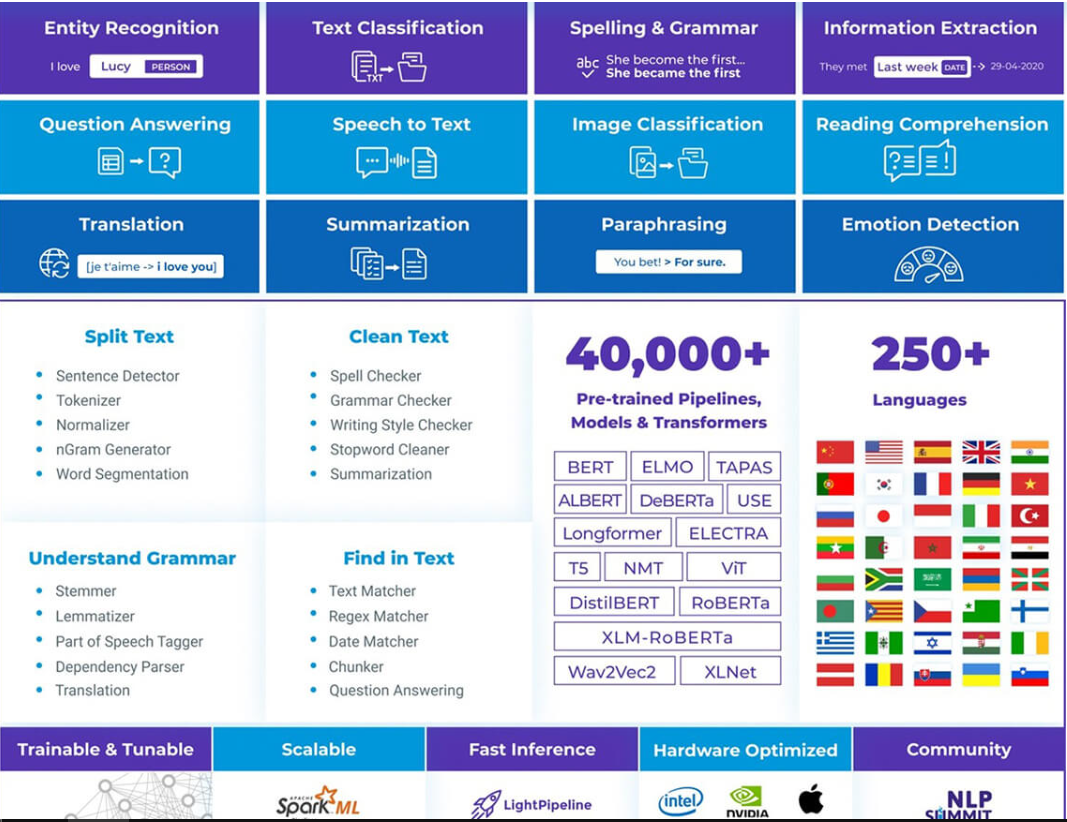

## Colab Setup

In [ ]:
!pip install -q pyspark==3.4.1 spark-nlp==5.3.2

In [ ]:
import sparknlp

spark = sparknlp.start()

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.3.2
Apache Spark version: 3.4.1


## LemmatizerModel

In [ ]:
from pyspark.ml import Pipeline

In [ ]:
!wget -q -O news_category_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv

In [ ]:
import pyspark.sql.functions as F

news_df = spark.read\
                .option("header", "true")\
                .csv("news_category_test.csv")\
                .withColumnRenamed("description", "text")

news_df.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                              text|
+--------+--------------------------------------------------+
|Business|Unions representing workers at Turner   Newall ...|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers...|
|Sci/Tech| A company founded by a chemistry researcher at...|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts ...|
|Sci/Tech| Southern California's smog fighting agency wen...|
|Sci/Tech|"The British Department for Education and Skill...|
|Sci/Tech|"confessed author of the Netsky and Sasser viru...|
|Sci/Tech|\\FOAF/LOAF  and bloom filters have a lot of in...|
|Sci/Tech|"Wiltshire Police warns about ""phishing"" afte...|
|Sci/Tech|In its first two years, the UK's dedicated card...|
|Sci/Tech| A group of technology companies  including Tex...|
|Sci/Tech| Apple Computer Inc.&lt;AAPL.O&gt; on  Tuesday ...|
|Sci/Tech| Free Record Shop, a Dutch music  retail chain,...|
|Sci/Tec

In [ ]:
lemmatizer = LemmatizerModel.pretrained('lemma_antbnc', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \

'''
lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")
'''

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


'\nlemmatizer = Lemmatizer()     .setInputCols(["token"])     .setOutputCol("lemma")     .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")\n'

In [ ]:
!cd ~/cache_pretrained && ls -l

total 4
drwxr-xr-x 4 root root 4096 Apr  6 13:05 lemma_antbnc_en_2.0.2_2.4_1556480454569


In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")


nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        stemmer,
        lemmatizer])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[{document, 0, 12...|[{token, 0, 5, Un...|[{token, 0, 5, un...|[{token, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[{document, 0, 22...|[{token, 1, 7, TO...|[{token, 1, 7, to...|[{token, 1, 7, TO...|
|Sci/Tech| A company founde...|[{document, 0, 20...|[{token, 1, 1, A,...|[{token, 1, 1, a,...|[{token, 1, 1, A,...|
|Sci/Tech| It's barely dawn...|[{document, 0, 26...|[{token, 1, 4, It...|[{token, 1, 4, it...|[{token, 1, 4, It...|
|Sci/Tech| Southern Califor...|[{document, 0, 17...|[{token, 1, 8, So...|[{token, 1, 8, so...|[{token, 1, 8, So...|
+--------+--------------------+--------------------+--------------------

In [ ]:
result.select('token.result','lemma.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|[Unions, represent, worker, at, Turner, Newall, say, they, be, ', disappointed, ', after, talk, w...|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[TORONTO, ,, Canada, A, second, team, of, rocketeer, compete, for, the, #36;10, mi

## PerceptronModel (POS - Part of speech tags)

In [ ]:
import pandas as pd

pos_df= pd.read_html('https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html', header=0)

pos_df[0]

,Number,Tag,Description
0,1.0,CC,Coordinating conjunction
1,2.0,CD,Cardinal number
2,3.0,DT,Determiner
3,4.0,EX,Existential there
4,5.0,FW,Foreign word
5,6.0,IN,Preposition or subordinating conjunction
6,7.0,JJ,Adjective
7,8.0,JJR,"Adjective, comparative"
8,9.0,JJS,"Adjective, superlative"
9,10.0,LS,List item marker


In [ ]:
pos = PerceptronModel.pretrained("pos_anc", 'en')\
          .setInputCols("document", "token")\
          .setOutputCol("pos")

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [ ]:
!cd ~/cache_pretrained && ls -l

total 8
drwxr-xr-x 4 root root 4096 Apr  6 13:05 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Apr  6 13:06 pos_anc_en_3.0.0_3.0_1614962126490


In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               stemmer,
                               lemmatizer,
                               pos])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[{document, 0, 12...|[{token, 0, 5, Un...|[{token, 0, 5, un...|[{token, 0, 5, Un...|[{pos, 0, 5, NNP,...|
|Sci/Tech| TORONTO, Canada ...|[{document, 0, 22...|[{token, 1, 7, TO...|[{token, 1, 7, to...|[{token, 1, 7, TO...|[{pos, 1, 7, NNP,...|
|Sci/Tech| A company founde...|[{document, 0, 20...|[{token, 1, 1, A,...|[{token, 1, 1, a,...|[{token, 1, 1, A,...|[{pos, 1, 1, DT, ...|
|Sci/Tech| It's barely dawn...|[{document, 0, 26...|[{token, 1, 4, It...|[{token, 1, 4, it...|[{token, 1, 4, It...|[{pos, 1, 4, NNP,...|
|Sci/Tech| Southern Califor...|[{document

In [ ]:
result.select('token.result','pos.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|    [NNP, VBG, NNS, IN, NNP, NNP, VBP, PRP, VBP, POS, JJ, POS, IN, NNS, IN, NN, NN, NN, NNP, NNP, .]|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[NNP, ,, NNP, DT, JJ, NN, IN, NNS, VBG, IN, DT, NN, CD, NNP, NNP, NNP, ,, DT, NN, 

In [ ]:
# applying this pipeline to top 100 rows and then converting to Pandas

result = pipelineModel.transform(news_df.limit(100))

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.token.begin,
                                                 result.token.end,
                                                 result.stem.result,
                                                 result.lemma.result,
                                                 result.pos.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end"),
                          F.expr("cols['3']").alias("stem"),
                          F.expr("cols['4']").alias("lemma"),
                          F.expr("cols['5']").alias("pos")).toPandas()

result_df.head(10)

,token,begin,end,stem,lemma,pos
0,Unions,0,5,union,Unions,NNP
1,representing,7,18,repres,represent,VBG
2,workers,20,26,worker,worker,NNS
3,at,28,29,at,at,IN
4,Turner,31,36,turner,Turner,NNP
5,Newall,40,45,newal,Newall,NNP
6,say,47,49,sai,say,VBP
7,they,51,54,thei,they,PRP
8,are,56,58,ar,be,VBP
9,',60,60,',',POS


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('Unions representing workers at Turner   Newall say they are disappointed after talks with stricken parent firm Federal Mogul.')

list(zip(light_result['token'], light_result['stem'], light_result['lemma'], light_result['pos']))

[('Unions', 'union', 'Unions', 'NNP'),
 ('representing', 'repres', 'represent', 'VBG'),
 ('workers', 'worker', 'worker', 'NNS'),
 ('at', 'at', 'at', 'IN'),
 ('Turner', 'turner', 'Turner', 'NNP'),
 ('Newall', 'newal', 'Newall', 'NNP'),
 ('say', 'sai', 'say', 'VBP'),
 ('they', 'thei', 'they', 'PRP'),
 ('are', 'ar', 'be', 'VBP'),
 ('disappointed', 'disappoint', 'disappointed', 'VBN'),
 ('after', 'after', 'after', 'IN'),
 ('talks', 'talk', 'talk', 'NNS'),
 ('with', 'with', 'with', 'IN'),
 ('stricken', 'stricken', 'stricken', 'NN'),
 ('parent', 'parent', 'parent', 'NN'),
 ('firm', 'firm', 'firm', 'NN'),
 ('Federal', 'feder', 'Federal', 'NNP'),
 ('Mogul', 'mogul', 'Mogul', 'NNP'),
 ('.', '.', '.', '.')]

In [ ]:
pd.DataFrame(list(zip(light_result['token'], light_result['stem'], light_result['lemma'], light_result['pos'])), columns = ['token', 'stem', 'lemma', 'pos'])

,token,stem,lemma,pos
0,Unions,union,Unions,NNP
1,representing,repres,represent,VBG
2,workers,worker,worker,NNS
3,at,at,at,IN
4,Turner,turner,Turner,NNP
5,Newall,newal,Newall,NNP
6,say,sai,say,VBP
7,they,thei,they,PRP
8,are,ar,be,VBP
9,disappointed,disappoint,disappointed,VBN


## **Chunker**

Meaningful phrase matching. This annotator matches a pattern of part-of-speech tags in order to return meaningful phrases from document

> **Output type**: Chunk

> **Input types**: Document, POS

Functions:

🔍`setRegexParsers(patterns)`: A list of regex patterns to match chunks, for example: Array(“‹DT›?‹JJ›*‹NN›

🔍`addRegexParser(patterns)`: adds a pattern to the current list of chunk patterns, for example: “‹DT›?‹JJ›*‹NN›”

In [ ]:
# applying POS chunker to find a custom pattern

chunker = Chunker()\
            .setInputCols(["document", "pos"])\
            .setOutputCol("chunk")\
            .setRegexParsers(["<NNP>+", "<DT>?<JJ>*<NN>"])

# NNP: Proper Noun
# NN: COmmon Noun
# DT: Determinator (e.g. the)
# JJ: Adjective

chunker.extractParamMap()

{Param(parent='Chunker_310a71bd2069', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='Chunker_310a71bd2069', name='inputCols', doc='previous annotations columns, if renamed'): ['document',
  'pos'],
 Param(parent='Chunker_310a71bd2069', name='outputCol', doc='output annotation column. can be left default.'): 'chunk',
 Param(parent='Chunker_310a71bd2069', name='regexParsers', doc='an array of grammar based chunk parsers'): ['<NNP>+',
  '<DT>?<JJ>*<NN>']}

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                              tokenizer,
                              stemmer,
                              lemmatizer,
                              pos,
                              chunker])

result = nlpPipeline.fit(news_df).transform(news_df.limit(100))
result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|               chunk|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[{document, 0, 12...|[{token, 0, 5, Un...|[{token, 0, 5, un...|[{token, 0, 5, Un...|[{pos, 0, 5, NNP,...|[{chunk, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[{document, 0, 22...|[{token, 1, 7, TO...|[{token, 1, 7, to...|[{token, 1, 7, TO...|[{pos, 1, 7, NNP,...|[{chunk, 1, 7, TO...|
|Sci/Tech| A company founde...|[{document, 0, 20...|[{token, 1, 1, A,...|[{token, 1, 1, a,...|[{token, 1, 1, A,...|[{pos, 1, 1, DT, ...|[{chunk, 52, 61, ...|
|Sci/Tech| It's barely dawn...|[{document, 0, 26...|

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.chunk.result,
                                                 result.chunk.begin,
                                                 result.chunk.end)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end")).toPandas()

result_df.head(10)

,chunk,begin,end
0,Unions,0,5
1,Turner Newall,31,45
2,Federal Mogul,113,125
3,stricken,92,99
4,parent,101,106
5,firm,108,111
6,TORONTO,1,7
7,Canada,10,15
8,Ansari X Prize,82,95
9,A second team,20,32


## **Dependency Parser**

The practice of analyzing the relationships between sentences in a phrase to ascertain its grammatical structure is known as dependency parsing (DP). Based on this, sentences are frequently broken up into multiple sections. The method is predicated on the idea that each language component in a phrase has a direct link with the others. Dependencies are the names given to these relationships.



In [ ]:
dep_parser = DependencyParserModel.pretrained('dependency_conllu')\
                .setInputCols(["document", "pos", "token"])\
                .setOutputCol("dependency")

dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [ ]:
typed_dep_parser = TypedDependencyParserModel.pretrained('dependency_typed_conllu')\
                      .setInputCols(["token", "pos", "dependency"])\
                      .setOutputCol("dependency_type")

dependency_typed_conllu download started this may take some time.
Approximate size to download 2.4 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        stemmer,
        lemmatizer,
        pos,
        dep_parser,
        typed_dep_parser
        ])

result = nlpPipeline.fit(news_df).transform(news_df.limit(100))

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.token.begin,
                                                 result.token.end,
                                                 result.dependency.result,
                                                 result.dependency_type.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end"),
                          F.expr("cols['3']").alias("dependency"),
                          F.expr("cols['4']").alias("dependency_type")).toPandas()

result_df.head(10)

,chunk,begin,end,dependency,dependency_type
0,Unions,0,5,ROOT,root
1,representing,7,18,workers,amod
2,workers,20,26,Unions,flat
3,at,28,29,Turner,case
4,Turner,31,36,workers,flat
5,Newall,40,45,say,nsubj
6,say,47,49,Unions,parataxis
7,they,51,54,disappointed,nsubj
8,are,56,58,disappointed,nsubj
9,',60,60,disappointed,case


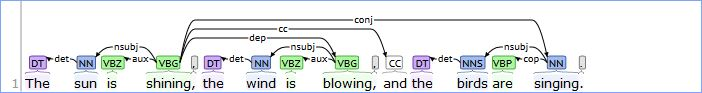

## **SpanBertCoref**

SpanBertCorefModel requires DOCUMENT and TOKEN type annotations. these are extracted first before being fed to the pretrained model for classification.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("tokens")

coref = SpanBertCorefModel() \
    .pretrained() \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("corefs")

pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    coref
])

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [ ]:
data = spark.createDataFrame([
    ["John loves Mary because she knows how to treat him. She is also fond of him. John said something to Mary but she didn't respond to him."],
]).toDF("text")

In [ ]:
model = pipeline.fit(data)

model.transform(data) \
    .selectExpr("explode(corefs) AS coref") \
    .selectExpr("coref.result as token", "coref.metadata") \
    .show(truncate=False)

+-----+------------------------------------------------------------------------------------+
|token|metadata                                                                            |
+-----+------------------------------------------------------------------------------------+
|Mary |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}|
|she  |{head.sentence -> 0, head -> Mary, head.begin -> 11, head.end -> 14, sentence -> 0} |
|She  |{head.sentence -> 0, head -> Mary, head.begin -> 11, head.end -> 14, sentence -> 1} |
|Mary |{head.sentence -> 0, head -> Mary, head.begin -> 11, head.end -> 14, sentence -> 2} |
|she  |{head.sentence -> 0, head -> Mary, head.begin -> 11, head.end -> 14, sentence -> 2} |
|John |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}|
|him  |{head.sentence -> 0, head -> John, head.begin -> 0, head.end -> 3, sentence -> 0}   |
|him  |{head.sentence -> 0, head -> John, head.begin -> 0, head.end ->

## **StopWordsCleaner**

`stopwords_fr`, `stopwords_de`, `stopwords_en`, `stopwords_it`, `stopwords_af` .... over 40 languages

In [ ]:
stopwords_cleaner = StopWordsCleaner.pretrained('stopwords_en','en')\
    .setInputCols("token")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


In [ ]:
# we can also get the list of stopwords

stopwords_cleaner_es = StopWordsCleaner.pretrained('stopwords_es','es')\
    .setInputCols("token")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

stopwords_cleaner_es.getStopWords()[:10]

stopwords_es download started this may take some time.
Approximate size to download 2.2 KB
[OK!]


['a',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'adrede',
 'ahi',
 'ahí',
 'ahora',
 'al']

In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

token_assembler = TokenAssembler() \
    .setInputCols(["document", "cleanTokens"]) \
    .setOutputCol("clean_text")


nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner,
        token_assembler
        ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('Peter Parker is a nice person and a friend of mine.')

light_result['clean_text']

['Peter Parker nice person friend mine.']

## **SpellChecker**


### Norvig Spell Checker

This annotator retrieves tokens and makes corrections automatically if not found in an English dictionary

In [ ]:
spell_checker_norvig = NorvigSweetingModel.pretrained('spellcheck_norvig')\
    .setInputCols("token")\
    .setOutputCol("corrected")

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [ ]:
from pyspark.sql.types import StringType

text_list = ['Peter Parker is a nice persn and lives in New York.',
             'Bruce Wayne is also a nice guy and lives in Gotham City.']

spark_df = spark.createDataFrame(text_list, StringType()).toDF("text")

spark_df.show(truncate=False)

+--------------------------------------------------------+
|text                                                    |
+--------------------------------------------------------+
|Peter Parker is a nice persn and lives in New York.     |
|Bruce Wayne is also a nice guy and lives in Gotham City.|
+--------------------------------------------------------+



In [ ]:
nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        stemmer,
        lemmatizer,
        pos,
        spell_checker_norvig
        ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(spark_df)

In [ ]:
from pyspark.sql import functions as F

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.corrected.result,
                                                 result.stem.result,
                                                 result.lemma.result,
                                                 result.pos.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("corrected"),
                          F.expr("cols['2']").alias("stem"),
                          F.expr("cols['3']").alias("lemma"),
                          F.expr("cols['4']").alias("pos")).toPandas()

result_df.head(10)

,token,corrected,stem,lemma,pos
0,Peter,Peter,peter,Peter,NNP
1,Parker,Parker,parker,Parker,NNP
2,is,is,i,be,VBZ
3,a,a,a,a,DT
4,nice,nice,nice,nice,JJ
5,persn,person,persn,persn,NN
6,and,and,and,and,CC
7,lives,lives,live,life,NNS
8,in,in,in,in,IN
9,New,New,new,New,NNP


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('The patint has pain and headace')

list(zip(light_result['token'], light_result['corrected']))

[('The', 'The'),
 ('patint', 'patient'),
 ('has', 'has'),
 ('pain', 'pain'),
 ('and', 'and'),
 ('headace', 'headache')]

### **Context SpellChecker**

The idea for this annotator is to have a flexible, configurable and "re-usable by parts" model.

Flexibility is the ability to accommodate different use cases for spell checking like OCR text, keyboard-input text, ASR text, and general spelling problems due to orthographic errors.

We say this is a configurable annotator, as you can adapt it yourself to different use cases avoiding re-training as much as possible.

Spell Checking at three levels: The final ranking of a correction sequence is affected by three things,

Different correction candidates for each word - **word level**.

The surrounding text of each word, i.e. it's context - **sentence level**.

The relative cost of different correction candidates according to the edit operations at the character level it requires - **subword level**.

In [ ]:
spellModel = ContextSpellCheckerModel.pretrained('spellcheck_dl')\
    .setInputCols("token")\
    .setOutputCol("checked")

finisher = Finisher()\
    .setInputCols("checked")

pipeline = Pipeline(
    stages = [
        documentAssembler,
        tokenizer,
        spellModel,
        finisher
        ])

empty_ds = spark.createDataFrame([[""]]).toDF("text")

sc_model = pipeline.fit(empty_ds)
lp = LightPipeline(sc_model)

spellcheck_dl download started this may take some time.
Approximate size to download 95.1 MB
[OK!]


In [ ]:
lp.annotate("Plaese alliow me tao introdduce myhelf, I am a man of waelth and tiaste")

{'checked': ['Please',
  'allow',
  'me',
  'to',
  'introduce',
  'myself',
  ',',
  'I',
  'am',
  'a',
  'man',
  'of',
  'wealth',
  'and',
  'taste']}

In [ ]:
from pyspark.sql.types import StringType

examples = ['We will go to swimming if the ueather is sunny.',\
            "I have a black ueather jacket, so nice.",\
            "I introduce you to my sister, she is called ueather."]

spark_df = spark.createDataFrame(examples, StringType()).toDF("text")

results = sc_model.transform(spark_df)
results.show(truncate=False)

+----------------------------------------------------+-------------------------------------------------------------------+
|text                                                |finished_checked                                                   |
+----------------------------------------------------+-------------------------------------------------------------------+
|We will go to swimming if the ueather is sunny.     |[We, will, go, to, swimming, if, the, weather, is, sunny, .]       |
|I have a black ueather jacket, so nice.             |[I, have, a, black, leather, jacket, ,, so, nice, .]               |
|I introduce you to my sister, she is called ueather.|[I, introduce, you, to, my, sister, ,, she, is, called, Heather, .]|
+----------------------------------------------------+-------------------------------------------------------------------+



## **Language Detector**

Language detection and identification is the task of automatically detecting the language(s) present in a document based on the content of the document. `LanguageDetectorDL` is an annotator that detects the language of documents or sentences depending on the inputCols. In addition, LanguageDetetorDL can accurately detect language from documents with mixed languages by coalescing sentences and select the best candidate.

In [ ]:
LanguageDetectorDL().extractParamMap()

{Param(parent='LanguageDetectorDL_01e290b6a61a', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='LanguageDetectorDL_01e290b6a61a', name='threshold', doc='The minimum threshold for the final result otheriwse it will be either neutral or the value set in thresholdLabel.'): 0.5,
 Param(parent='LanguageDetectorDL_01e290b6a61a', name='thresholdLabel', doc='In case the score is less than threshold, what should be the label. Default is neutral.'): 'Unknown',
 Param(parent='LanguageDetectorDL_01e290b6a61a', name='coalesceSentences', doc='If sets to true the output of all sentences will be averaged to one output instead of one output per sentence. Default to false.'): True}

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained("ld_wiki_tatoeba_cnn_375", "xx")\
    .setInputCols("document")\
    .setOutputCol("language")\
    .setThreshold(0.5)\
    .setCoalesceSentences(True)

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        languageDetector
        ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

ld_wiki_tatoeba_cnn_375 download started this may take some time.
Approximate size to download 8.8 MB
[OK!]


In [ ]:
light_model = LightPipeline(pipelineModel)


In [ ]:
text_en = "William Henry Gates III (born October 28, 1955) is an American business magnate, software developer, investor, and philanthropist. He is best known as the co-founder of Microsoft Corporation. During his career at Microsoft, Gates held the positions of chairman, chief executive officer (CEO), president and chief software architect, while also being the largest individual shareholder until May 2014."

text_de = 'Als Sebastian Thrun 2007 bei Google anfing, an selbstfahrenden Autos zu arbeiten, nahmen ihn nur wenige Leute außerhalb des Unternehmens ernst.'

text_es = "La historia del procesamiento del lenguaje natural generalmente comenzó en la década de 1950, aunque se puede encontrar trabajo de períodos anteriores. En 1950, Alan Turing publicó un artículo titulado 'Maquinaria de computación e inteligencia' que proponía lo que ahora se llama la prueba de Turing como criterio de inteligencia"

text_it = "Geoffrey Everest Hinton è uno psicologo cognitivo e uno scienziato informatico canadese inglese, noto soprattutto per il suo lavoro sulle reti neurali artificiali. Dal 2013 divide il suo tempo lavorando per Google e l'Università di Toronto. Nel 2017 è stato cofondatore ed è diventato Chief Scientific Advisor del Vector Institute di Toronto."

text_tr = 'Doğal Dil İşleme (NLP), bilgisayar biliminin, insanlar doğal olarak konuşup yazdıkça insan dilini anlamasını sağlayan bilgisayar biliminin alt alanıdır. '

In [ ]:
light_model.annotate(text_tr)['language']

['tr']

In [ ]:
light_model.annotate(text_es)['language']

['es']

In [ ]:
light_model.fullAnnotate(text_es)[0]['language']

[Annotation(language, 0, 328, es, {'avk': '3.2228143E-25', 'toki': '0.0', 'dng': '0.0', 'hy': '0.0', 'bua': '0.0', 'pcd': '1.9256214E-31', 'se': '3.0614187E-33', 'nlv': '0.0', 'ku': '1.6084695E-30', 'gcf': '0.0', 'xmf': '0.0', 'rue': '0.0', 'lou': '0.0', 'crh': '0.0', 'lkt': '0.0', 'oar': '0.0', 'aoz': '0.0', 'ss': '0.0', 'st': '0.0', 'ota': '0.0', 'bs': '7.27877E-36', 'cho': '0.0', 'stq': '0.0', 'kaa': '0.0', 'ba': '0.0', 'ngu': '0.0', 'pfl': '0.0', 'lb': '6.1421795E-24', 'hr': '3.8482767E-28', 'ta': '0.0', 'ka': '0.0', 'ar': '0.0', 'lzz': '0.0', 'swh': '0.0', 'hbo': '0.0', 'pi': '0.0', 'nov': '9.696418E-25', 'yue': '0.0', 'ty': '0.0', 'fr': '2.2967787E-22', 'lfn': '5.510016E-9', 'is': '1.7047977E-29', 'urh': '0.0', 'mgm': '0.0', 'nah': '0.0', 'ug': '0.0', 'otk': '0.0', 'lv': '0.0', 'tmw': '0.0', 'eu': '1.03383434E-22', 'mdf': '0.0', 'got': '0.0', 'kl': '0.0', 'rn': '0.0', 'emx': '0.0', 'vep': '0.0', 'am': '0.0', 'hif': '0.0', 'mt': '4.7177047E-21', 'krc': '0.0', 'bn': '0.0', 'rw': '0

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

pipeline = PretrainedPipeline("detect_language_220", lang = "xx")

pipeline.annotate("French author who helped pioneer the science-fiction genre.")

detect_language_220 download started this may take some time.
Approx size to download 9.1 MB
[OK!]


{'document': ['French author who helped pioneer the science-fiction genre.'],
 'sentence': ['French author who helped pioneer the science-fiction genre.'],
 'language': ['en']}

## **Embeddings**

**Here is the Multi-Lingual Embeddings Model List avaliable in Spark NLP:**

| title                                                                                                                  | name                                   | language   |
|:-----------------------------------------------------------------------------------------------------------------------|:---------------------------------------|:-----------|
| Glove Embeddings 6B 100                                                                                                | glove_100d                             | en         |
| GloVe Embeddings 6B 300 (Multilingual)                                                                                 | glove_6B_300                           | xx         |
| GloVe Embeddings 840B 300 (Multilingual)                                                                               | glove_840B_300                         | xx         |
| Embeddings Clinical                                                                                                    | embeddings_clinical                    | en         |
| ELMo Embeddings                                                                                                        | elmo                                   | en         |
| Embeddings Healthcare                                                                                                  | embeddings_healthcare                  | en         |
| Universal Sentence Encoder                                                                                             | tfhub_use                              | en         |
| Universal Sentence Encoder Large                                                                                       | tfhub_use_lg                           | en         |
| ALBERT Embeddings (Base Uncase)                                                                                        | albert_base_uncased                    | en         |
| ALBERT Embeddings (Large Uncase)                                                                                       | albert_large_uncased                   | en         |
| ALBERT Embeddings (XLarge Uncase)                                                                                      | albert_xlarge_uncased                  | en         |
| ALBERT Embeddings (XXLarge Uncase)                                                                                     | albert_xxlarge_uncased                 | en         |
| XLNet Embeddings (Base)                                                                                                | xlnet_base_cased                       | en         |
| XLNet Embeddings (Large)                                                                                               | xlnet_large_cased                      | en         |
| Embeddings Scielo 150 dims                                                                                             | embeddings_scielo_150d                 | es         |
| Embeddings Scielo 300 dims                                                                                             | embeddings_scielo_300d                 | es         |
| Embeddings Scielo 50 dims                                                                                              | embeddings_scielo_50d                  | es         |
| Embeddings Scielowiki 150 dims                                                                                         | embeddings_scielowiki_150d             | es         |
| Embeddings Scielowiki 300 dims                                                                                         | embeddings_scielowiki_300d             | es         |
| Embeddings Scielowiki 50 dims                                                                                          | embeddings_scielowiki_50d              | es         |
| Embeddings Sciwiki 150 dims                                                                                            | embeddings_sciwiki_150d                | es         |
| Embeddings Sciwiki 300 dims                                                                                            | embeddings_sciwiki_300d                | es         |
| Embeddings Sciwiki 50 dims                                                                                             | embeddings_sciwiki_50d                 | es         |
| Embeddings Healthcare 100 dims                                                                                         | embeddings_healthcare_100d             | en         |
| Embeddings BioVec                                                                                                      | embeddings_biovec                      | en         |
| BERT Embeddings (Base Cased)                                                                                           | bert_base_cased                        | en         |
| BERT Embeddings (Base Uncased)                                                                                         | bert_base_uncased                      | en         |
| BERT Embeddings (Large Cased)                                                                                          | bert_large_cased                       | en         |
| BERT Embeddings (Large Uncased)                                                                                        | bert_large_uncased                     | en         |
| Multilingual BERT Embeddings (Base Cased)                                                                              | bert_multi_cased                       | xx         |
| BioBERT Embeddings (Clinical)                                                                                          | biobert_clinical_base_cased            | en         |
| BioBERT Embeddings (Discharge)                                                                                         | biobert_discharge_base_cased           | en         |
| BioBERT Embeddings (PMC)                                                                                               | biobert_pmc_base_cased                 | en         |
| BioBERT Embeddings (Pubmed)                                                                                            | biobert_pubmed_base_cased              | en         |
| BioBERT Embeddings (Pubmed Large)                                                                                      | biobert_pubmed_large_cased             | en         |
| BioBERT Embeddings (Pubmed PMC)                                                                                        | biobert_pubmed_pmc_base_cased          | en         |
| BioBERT Sentence Embeddings (Clinical)                                                                                 | sent_biobert_clinical_base_cased       | en         |
| BERT Sentence Embeddings (Base Cased)                                                                                  | sent_bert_base_cased                   | en         |
| BERT Sentence Embeddings (Base Uncased)                                                                                | sent_bert_base_uncased                 | en         |
| BERT Sentence Embeddings (Large Cased)                                                                                 | sent_bert_large_cased                  | en         |
| BERT Sentence Embeddings (Large Uncased)                                                                               | sent_bert_large_uncased                | en         |
| Multilingual BERT Sentence Embeddings (Base Cased)                                                                     | sent_bert_multi_cased                  | xx         |
| BioBERT Sentence Embeddings (Discharge)                                                                                | sent_biobert_discharge_base_cased      | en         |
| BioBERT Sentence Embeddings (PMC)                                                                                      | sent_biobert_pmc_base_cased            | en         |
| BioBERT Sentence Embeddings (Pubmed)                                                                                   | sent_biobert_pubmed_base_cased         | en         |
| BioBERT Sentence Embeddings (Pubmed Large)                                                                             | sent_biobert_pubmed_large_cased        | en         |
| BioBERT Sentence Embeddings (Pubmed PMC)                                                                               | sent_biobert_pubmed_pmc_base_cased     | en         |
| Smaller BERT Sentence Embeddings (L-10_H-128_A-2)                                                                      | sent_small_bert_L10_128                | en         |
| Smaller BERT Sentence Embeddings (L-10_H-256_A-4)                                                                      | sent_small_bert_L10_256                | en         |
| Smaller BERT Sentence Embeddings (L-10_H-512_A-8)                                                                      | sent_small_bert_L10_512                | en         |
| Smaller BERT Sentence Embeddings (L-10_H-768_A-12)                                                                     | sent_small_bert_L10_768                | en         |
| Smaller BERT Sentence Embeddings (L-12_H-128_A-2)                                                                      | sent_small_bert_L12_128                | en         |
| Smaller BERT Sentence Embeddings (L-12_H-256_A-4)                                                                      | sent_small_bert_L12_256                | en         |
| Smaller BERT Sentence Embeddings (L-12_H-512_A-8)                                                                      | sent_small_bert_L12_512                | en         |
| Smaller BERT Sentence Embeddings (L-12_H-768_A-12)                                                                     | sent_small_bert_L12_768                | en         |
| Smaller BERT Sentence Embeddings (L-2_H-128_A-2)                                                                       | sent_small_bert_L2_128                 | en         |
| Smaller BERT Sentence Embeddings (L-2_H-256_A-4)                                                                       | sent_small_bert_L2_256                 | en         |
| Smaller BERT Sentence Embeddings (L-2_H-512_A-8)                                                                       | sent_small_bert_L2_512                 | en         |
| Smaller BERT Sentence Embeddings (L-2_H-768_A-12)                                                                      | sent_small_bert_L2_768                 | en         |
| Smaller BERT Sentence Embeddings (L-4_H-128_A-2)                                                                       | sent_small_bert_L4_128                 | en         |
| Smaller BERT Sentence Embeddings (L-4_H-256_A-4)                                                                       | sent_small_bert_L4_256                 | en         |
| Smaller BERT Sentence Embeddings (L-4_H-512_A-8)                                                                       | sent_small_bert_L4_512                 | en         |
| Smaller BERT Sentence Embeddings (L-4_H-768_A-12)                                                                      | sent_small_bert_L4_768                 | en         |
| Smaller BERT Sentence Embeddings (L-6_H-128_A-2)                                                                       | sent_small_bert_L6_128                 | en         |
| Smaller BERT Sentence Embeddings (L-6_H-256_A-4)                                                                       | sent_small_bert_L6_256                 | en         |
| Smaller BERT Sentence Embeddings (L-6_H-512_A-8)                                                                       | sent_small_bert_L6_512                 | en         |
| Smaller BERT Sentence Embeddings (L-6_H-768_A-12)                                                                      | sent_small_bert_L6_768                 | en         |
| Smaller BERT Sentence Embeddings (L-8_H-128_A-2)                                                                       | sent_small_bert_L8_128                 | en         |
| Smaller BERT Sentence Embeddings (L-8_H-256_A-4)                                                                       | sent_small_bert_L8_256                 | en         |
| Smaller BERT Sentence Embeddings (L-8_H-512_A-8)                                                                       | sent_small_bert_L8_512                 | en         |
| Smaller BERT Sentence Embeddings (L-8_H-768_A-12)                                                                      | sent_small_bert_L8_768                 | en         |
| Smaller BERT Embeddings (L-10_H-128_A-2)                                                                               | small_bert_L10_128                     | en         |
| Smaller BERT Embeddings (L-10_H-256_A-4)                                                                               | small_bert_L10_256                     | en         |
| Smaller BERT Embeddings (L-10_H-512_A-8)                                                                               | small_bert_L10_512                     | en         |
| Smaller BERT Embeddings (L-10_H-768_A-12)                                                                              | small_bert_L10_768                     | en         |
| Smaller BERT Embeddings (L-12_H-128_A-2)                                                                               | small_bert_L12_128                     | en         |
| Smaller BERT Embeddings (L-12_H-256_A-4)                                                                               | small_bert_L12_256                     | en         |
| Smaller BERT Embeddings (L-12_H-512_A-8)                                                                               | small_bert_L12_512                     | en         |
| Smaller BERT Embeddings (L-12_H-768_A-12)                                                                              | small_bert_L12_768                     | en         |
| Smaller BERT Embeddings (L-2_H-128_A-2)                                                                                | small_bert_L2_128                      | en         |
| Smaller BERT Embeddings (L-2_H-256_A-4)                                                                                | small_bert_L2_256                      | en         |
| Smaller BERT Embeddings (L-2_H-512_A-8)                                                                                | small_bert_L2_512                      | en         |
| Smaller BERT Embeddings (L-2_H-768_A-12)                                                                               | small_bert_L2_768                      | en         |
| Smaller BERT Embeddings (L-4_H-128_A-2)                                                                                | small_bert_L4_128                      | en         |
| Smaller BERT Embeddings (L-4_H-256_A-4)                                                                                | small_bert_L4_256                      | en         |
| Smaller BERT Embeddings (L-4_H-512_A-8)                                                                                | small_bert_L4_512                      | en         |
| Smaller BERT Embeddings (L-4_H-768_A-12)                                                                               | small_bert_L4_768                      | en         |
| Smaller BERT Embeddings (L-6_H-128_A-2)                                                                                | small_bert_L6_128                      | en         |
| Smaller BERT Embeddings (L-6_H-256_A-4)                                                                                | small_bert_L6_256                      | en         |
| Smaller BERT Embeddings (L-6_H-512_A-8)                                                                                | small_bert_L6_512                      | en         |
| Smaller BERT Embeddings (L-6_H-768_A-12)                                                                               | small_bert_L6_768                      | en         |
| Smaller BERT Embeddings (L-8_H-128_A-2)                                                                                | small_bert_L8_128                      | en         |
| Smaller BERT Embeddings (L-8_H-256_A-4)                                                                                | small_bert_L8_256                      | en         |
| Smaller BERT Embeddings (L-8_H-512_A-8)                                                                                | small_bert_L8_512                      | en         |
| Smaller BERT Embeddings (L-8_H-768_A-12)                                                                               | small_bert_L8_768                      | en         |
| COVID BERT Embeddings (Large Uncased)                                                                                  | covidbert_large_uncased                | en         |
| ELECTRA Embeddings(ELECTRA Base)                                                                                       | electra_base_uncased                   | en         |
| ELECTRA Embeddings(ELECTRA Small)                                                                                      | electra_large_uncased                  | en         |
| ELECTRA Embeddings(ELECTRA Small)                                                                                      | electra_small_uncased                  | en         |
| COVID BERT Sentence Embeddings (Large Uncased)                                                                         | sent_covidbert_large_uncased           | en         |
| ELECTRA Sentence Embeddings(ELECTRA Base)                                                                              | sent_electra_base_uncased              | en         |
| ELECTRA Sentence Embeddings(ELECTRA Large)                                                                             | sent_electra_large_uncased             | en         |
| ELECTRA Sentence Embeddings(ELECTRA Small)                                                                             | sent_electra_small_uncased             | en         |
| Finnish BERT Embeddings (Base Cased)                                                                                   | bert_finnish_cased                     | fi         |
| Finnish BERT Embeddings (Base Uncased)                                                                                 | bert_finnish_uncased                   | fi         |
| Finnish BERT Sentence Embeddings (Base Cased)                                                                          | sent_bert_finnish_cased                | fi         |
| Finnish BERT Sentence Embeddings (Base Uncased)                                                                        | sent_bert_finnish_uncased              | fi         |
| Fastext Word Embeddings in German                                                                                      | w2v_cc_300d                            | de         |
| BioBERT Embeddings (Clinical)                                                                                          | biobert_clinical_base_cased            | en         |
| BioBERT Embeddings (Discharge)                                                                                         | biobert_discharge_base_cased           | en         |
| BioBERT Embeddings (PMC)                                                                                               | biobert_pmc_base_cased                 | en         |
| BioBERT Embeddings (Pubmed)                                                                                            | biobert_pubmed_base_cased              | en         |
| BioBERT Embeddings (Pubmed Large)                                                                                      | biobert_pubmed_large_cased             | en         |
| BioBERT Embeddings (Pubmed PMC)                                                                                        | biobert_pubmed_pmc_base_cased          | en         |
| BioBERT Sentence Embeddings (Clinical)                                                                                 | sent_biobert_clinical_base_cased       | en         |
| BioBERT Sentence Embeddings (Discharge)                                                                                | sent_biobert_discharge_base_cased      | en         |
| BioBERT Sentence Embeddings (PMC)                                                                                      | sent_biobert_pmc_base_cased            | en         |
| BioBERT Sentence Embeddings (Pubmed)                                                                                   | sent_biobert_pubmed_base_cased         | en         |
| BioBERT Sentence Embeddings (Pubmed Large)                                                                             | sent_biobert_pubmed_large_cased        | en         |
| BioBERT Sentence Embeddings (Pubmed PMC)                                                                               | sent_biobert_pubmed_pmc_base_cased     | en         |
| BERT LaBSE Sentence Embeddings                                                                                         | labse                                  | en         |
| Portuguese BERT Embeddings (Base Cased)                                                                                | bert_portuguese_base_cased             | pt         |
| Portuguese BERT Embeddings (Large Cased)                                                                               | bert_portuguese_large_cased            | pt         |
| Sentence Embeddings - Biobert cased (MedNLI)                                                                           | sbiobert_base_cased_mli                | en         |
| Sentence Embeddings - Bluebert uncased (MedNLI)                                                                        | sbluebert_base_uncased_mli             | en         |
| Word Embeddings for Urdu (urduvec_140M_300d)                                                                           | urduvec_140M_300d                      | ur         |
| Word Embeddings for Arabic (arabic_w2v_cc_300d)                                                                        | arabic_w2v_cc_300d                     | ar         |
| Word Embeddings for Persian (persian_w2v_cc_300d)                                                                      | persian_w2v_cc_300d                    | fa         |
| Universal Sentence Encoder Multilingual Large                                                                          | tfhub_use_multi_lg                     | xx         |
| Universal Sentence Encoder Multilingual                                                                                | tfhub_use_multi                        | xx         |
| Universal Sentence Encoder XLING English and German                                                                    | tfhub_use_xling_en_de                  | xx         |
| Universal Sentence Encoder XLING English and Spanish                                                                   | tfhub_use_xling_en_es                  | xx         |
| Universal Sentence Encoder XLING English and French                                                                    | tfhub_use_xling_en_fr                  | xx         |
| Universal Sentence Encoder XLING Many                                                                                  | tfhub_use_xling_many                   | xx         |
| Word Embeddings for Hebrew (hebrew_cc_300d)                                                                            | hebrew_cc_300d                         | he         |
| Word Embeddings for Hindi (hindi_cc_300d)                                                                              | hindi_cc_300d                          | hi         |
| Word Embeddings for Bengali (bengali_cc_300d)                                                                          | bengali_cc_300d                        | bn         |
| Universal Sentence Encoder Multilingual Large (tfhub_use_multi_lg)                                                     | tfhub_use_multi_lg                     | xx         |
| Universal Sentence Encoder Multilingual (tfhub_use_multi)                                                              | tfhub_use_multi                        | xx         |
| Sentence Embeddings - sbert medium (tuned)                                                                             | sbert_jsl_medium_umls_uncased          | en         |
| Sentence Embeddings - sbert medium (tuned)                                                                             | sbert_jsl_medium_uncased               | en         |
| Sentence Embeddings - sbert mini (tuned)                                                                               | sbert_jsl_mini_umls_uncased            | en         |
| Sentence Embeddings - sbert mini (tuned)                                                                               | sbert_jsl_mini_uncased                 | en         |
| Sentence Embeddings - sbert tiny (tuned)                                                                               | sbert_jsl_tiny_umls_uncased            | en         |
| Sentence Embeddings - sbert tiny (tuned)                                                                               | sbert_jsl_tiny_uncased                 | en         |
| Sentence Embeddings - sbiobert (tuned)                                                                                 | sbiobert_jsl_cased                     | en         |
| Sentence Embeddings - sbiobert (tuned)                                                                                 | sbiobert_jsl_umls_cased                | en         |
| Chinese BERT Base                                                                                                      | bert_base_chinese                      | zh         |
| BERTje A Dutch BERT model                                                                                              | bert_base_dutch_cased                  | nl         |
| German BERT Base Cased Model                                                                                           | bert_base_german_cased                 | de         |
| German BERT Base Uncased Model                                                                                         | bert_base_german_uncased               | de         |
| Italian BERT Base Cased                                                                                                | bert_base_italian_cased                | it         |
| Italian BERT Base Uncased                                                                                              | bert_base_italian_uncased              | it         |
| BERT multilingual base model (cased)                                                                                   | bert_base_multilingual_cased           | xx         |
| BERT multilingual base model (uncased)                                                                                 | bert_base_multilingual_uncased         | xx         |
| Turkish BERT Base Cased (BERTurk)                                                                                      | bert_base_turkish_cased                | tr         |
| Turkish BERT Base Uncased (BERTurk)                                                                                    | bert_base_turkish_uncased              | tr         |
| Chinese BERT with Whole Word Masking                                                                                   | chinese_bert_wwm                       | zh         |
| DistilBERT base model (cased)                                                                                          | distilbert_base_cased                  | en         |
| DistilBERT base multilingual model (cased)                                                                             | distilbert_base_multilingual_cased     | xx         |
| DistilBERT base model (uncased)                                                                                        | distilbert_base_uncased                | en         |
| DistilRoBERTa base model                                                                                               | distilroberta_base                     | en         |
| RoBERTa base model                                                                                                     | roberta_base                           | en         |
| RoBERTa large model                                                                                                    | roberta_large                          | en         |
| Twitter XLM-RoBERTa Base (twitter_xlm_roberta_base)                                                                    | twitter_xlm_roberta_base               | xx         |
| XLM-RoBERTa Base (xlm_roberta_base)                                                                                    | xlm_roberta_base                       | xx         |
| ALBERT Embeddings (Base Uncase)                                                                                        | albert_base_uncased                    | en         |
| ALBERT Embeddings (Large Uncase)                                                                                       | albert_large_uncased                   | en         |
| ALBERT Embeddings (XLarge Uncase)                                                                                      | albert_xlarge_uncased                  | en         |
| ALBERT Embeddings (XXLarge Uncase)                                                                                     | albert_xxlarge_uncased                 | en         |
| Sentence Embeddings - sbert medium (tuned)                                                                             | sbert_jsl_medium_umls_uncased          | en         |
| Sentence Embeddings - sbert medium (tuned)                                                                             | sbert_jsl_medium_uncased               | en         |
| Sentence Embeddings - sbert mini (tuned)                                                                               | sbert_jsl_mini_umls_uncased            | en         |
| Sentence Embeddings - sbert mini (tuned)                                                                               | sbert_jsl_mini_uncased                 | en         |
| Sentence Embeddings - sbert tiny (tuned)                                                                               | sbert_jsl_tiny_umls_uncased            | en         |
| Sentence Embeddings - sbert tiny (tuned)                                                                               | sbert_jsl_tiny_uncased                 | en         |
| Sentence Embeddings - sbiobert (tuned)                                                                                 | sbiobert_jsl_cased                     | en         |
| Sentence Embeddings - sbiobert (tuned)                                                                                 | sbiobert_jsl_umls_cased                | en         |
| Chinese Pre-Trained XLNet (Base)                                                                                       | chinese_xlnet_base                     | zh         |
| XLNet Embeddings (Base Cased)                                                                                          | xlnet_base_cased                       | en         |
| XLNet Embeddings (Large Cased)                                                                                         | xlnet_large_cased                      | en         |
| XLM-RoBERTa XTREME Base (xlm_roberta_xtreme_base)                                                                      | xlm_roberta_xtreme_base                | xx         |
| Universal sentence encoder for English trained with CMLM (sent_bert_use_cmlm_en_base)                                  | sent_bert_use_cmlm_en_base             | en         |
| Universal sentence encoder for English trained with CMLM (sent_bert_use_cmlm_en_large)                                 | sent_bert_use_cmlm_en_large            | en         |
| Universal sentence encoder for 100+ languages trained with CMLM (sent_bert_use_cmlm_multi_base_br)                     | sent_bert_use_cmlm_multi_base_br       | xx         |
| Universal sentence encoder for 100+ languages trained with CMLM (sent_bert_use_cmlm_multi_base)                        | sent_bert_use_cmlm_multi_base          | xx         |
| MS-BERT base model (uncased)                                                                                           | ms_bluebert_base_uncased               | en         |
| Longformer Base (longformer_base_4096)                                                                                 | longformer_base_4096                   | en         |
| Longformer Large (longformer_large_4096)                                                                               | longformer_large_4096                  | en         |
| Multilingual Representations for Indian Languages (MuRIL)                                                              | bert_muril                             | xx         |
| BERT Embeddings trained on MEDLINE/PubMed                                                                              | bert_pubmed                            | en         |
| BERT Embeddings trained on MEDLINE/PubMed and fine-tuned on SQuAD 2.0                                                  | bert_pubmed_squad2                     | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus                                                                   | bert_wiki_books                        | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on MNLI                                            | bert_wiki_books_mnli                   | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on QNLI                                            | bert_wiki_books_qnli                   | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on QQP                                             | bert_wiki_books_qqp                    | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on SQuAD 2.0                                       | bert_wiki_books_squad2                 | en         |
| BERT Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on SST-2                                           | bert_wiki_books_sst2                   | en         |
| Sentence Detection in Telugu Text                                                                                      | sentence_detector_dl                   | te         |
| BERT Sentence Embeddings trained on MEDLINE/PubMed                                                                     | sent_bert_pubmed                       | en         |
| BERT Sentence Embeddings trained on MEDLINE/PubMed and fine-tuned on SQuAD 2.0                                         | sent_bert_pubmed_squad2                | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus                                                          | sent_bert_wiki_books                   | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on MNLI                                   | sent_bert_wiki_books_mnli              | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on QNLI                                   | sent_bert_wiki_books_qnli              | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on QQP                                    | sent_bert_wiki_books_qqp               | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on SQuAD 2.0                              | sent_bert_wiki_books_squad2            | en         |
| BERT Sentence Embeddings trained on Wikipedia and BooksCorpus and fine-tuned on SST-2                                  | sent_bert_wiki_books_sst2              | en         |
| Multilingual Representations for Indian Languages (MuRIL) - BERT Sentence Embedding pre-trained on 17 Indian languages | sent_bert_muril                        | xx         |
| DistilRoBERTa Base Sentence Embeddings(sent_distilroberta_base)                                                        | sent_distilroberta_base                | en         |
| RoBERTa Base Sentence Embeddings(sent_roberta_base)                                                                    | sent_roberta_base                      | en         |
| RoBERTa Large Sentence Embeddings(sent_roberta_large)                                                                  | sent_roberta_large                     | en         |
| XLM-RoBERTa Base Sentence Embeddings (sent_xlm_roberta_base)                                                           | sent_xlm_roberta_base                  | xx         |
| Spanish BERT Sentence Base Cased Embedding                                                                             | sent_bert_base_cased                   | es         |
| Dutch BERT Sentence Base Cased Embedding                                                                               | sent_bert_base_cased                   | nl         |
| Swedish BERT Sentence Base Cased Embedding                                                                             | sent_bert_base_cased                   | sv         |
| Greek BERT Sentence Base Uncased Embedding                                                                             | sent_bert_base_uncased                 | el         |
| Spanish BERT Sentence Base Uncased Embedding                                                                           | sent_bert_base_uncased                 | es         |
| Legal BERT Sentence Base Uncased Embedding                                                                             | sent_bert_base_uncased_legal           | en         |
| Spanish BERT Base Cased Embedding                                                                                      | bert_base_cased                        | es         |
| Dutch BERT Base Cased Embedding                                                                                        | bert_base_cased                        | nl         |
| Swedish BERT Base Cased Embedding                                                                                      | bert_base_cased                        | sv         |
| Greek BERT Base Uncased Embedding                                                                                      | bert_base_uncased                      | el         |
| Spanish BERT Base Uncased Embedding                                                                                    | bert_base_uncased                      | es         |
| Legal BERT Base Uncased Embedding                                                                                      | bert_base_uncased_legal                | en         |
| Word Embeddings for Japanese (japanese_cc_300d)                                                                        | japanese_cc_300d                       | ja         |
| Bert Embeddings Romanian (Base Cased)                                                                                  | bert_base_cased                        | ro         |
| BERT Sentence Embeddings German (Base Cased)                                                                           | sent_bert_base_cased                   | de         |
| Japanese BERT Base                                                                                                     | bert_base_japanese                     | ja         |
| XLM-RoBERTa Base for Amharic (xlm_roberta_base_finetuned_amharic)                                                      | xlm_roberta_base_finetuned_amharic     | am         |
| XLM-RoBERTa Base for Hausa (xlm_roberta_base_finetuned_hausa)                                                          | xlm_roberta_base_finetuned_hausa       | ha         |
| XLM-RoBERTa Base for Igbo (xlm_roberta_base_finetuned_igbo)                                                            | xlm_roberta_base_finetuned_igbo        | ig         |
| XLM-RoBERTa Base for Kinyarwanda (xlm_roberta_base_finetuned_kinyarwanda)                                              | xlm_roberta_base_finetuned_kinyarwanda | rw         |
| XLM-RoBERTa Base for Luganda (xlm_roberta_base_finetuned_luganda)                                                      | xlm_roberta_base_finetuned_luganda     | lg         |
| XLM-RoBERTa Large (xlm_roberta_large)                                                                                  | xlm_roberta_large                      | xx         |
| Word Embeddings for Dutch (dutch_cc_300d)                                                                              | dutch_cc_300d                          | nl         |

**You can find all these models and more [HERE](https://nlp.johnsnowlabs.com/models?task=Embeddings&edition=Spark+NLP)**

### Word Embeddings (Glove)

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               glove_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("embeddings"))

result_df.show(10, truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                          embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.71865, 0.80754, -1.1787, 0.27145, -0.48833, -0.18938, -1.1789, 0.17836, -0.21995, -0.7216, -0....|
|representing|[0.25671, 0.30035, -0.18006, 0.46666, 0.98501, 0.2321, -0.34959, 0.26997, -0.99667, -0.43404, -0....|
|     workers|[0.50592, 0.71717, -0.67236, -0.32112, -0.58285, -0.47977, -0.50243, 0.60594, 0.25709, 0.03974, -...|
|          at|[0.1766, 0.093851, 0.24351, 0.44313, -0.39037, 0.12524, -0.19918, 0.59855, -0.82035, 0.28006, 0.5...|
|      Turner|[0.51634, -0.37186, -0.21776, -1.0115, 0.4014, -0.4841, 0.36274, -0.2952, -0.42258, -0.62844, 0.6...|
|      Newall|[-0.38857, -1.1449, -0.41737, -0.31969, -0.16546, -0.7044,

#### Using your own Word embeddings in Spark NLP

In [ ]:
! wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.nl.300.vec.gz

In [ ]:
!gunzip cc.nl.300.vec.gz

In [ ]:
custom_embeddings = WordEmbeddings()\
                        .setInputCols(["document", "token"])\
                        .setOutputCol("my_embeddings")\
                        .setStoragePath('cc.nl.300.vec', "TEXT")\
                        .setDimension(300)

custom_embeddings_model = custom_embeddings.fit(result.limit(10))# any df would be fine as long as it had document and token columns thru Spark NLP

In [ ]:
custom_embeddings_model.transform(result.limit(10)).select('my_embeddings.embeddings').show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                          embeddings|
+----------------------------------------------------------------------------------------------------+
|[[-0.0724, -0.0156, -0.031, -0.0285, 0.0037, 0.0091, -0.0524, -0.0528, -0.0572, -0.0975, 0.0156, ...|
|[[0.0123, -0.0048, -0.0016, 0.015, 0.0078, 0.0286, -0.0042, -0.0298, 0.0143, -0.1116, 0.0151, -0....|
|[[0.0807, 0.032, -0.0031, 0.0422, 0.14, 0.0321, -0.1067, -0.1257, -0.0627, -0.2708, -0.0688, 0.11...|
|[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...|
|[[-0.0471, 0.025, -0.007, 0.055, -0.019, 0.0615, -0.0303, -0.0282, -0.0087, -0.037, 0.0122, -0.02...|
|[[-0.2369, 0.1427, 0.0382, -0.0638, 0.0302, 0.0055, -0.0086, -0.0269, 0.0066, 0.1798, -0.0224, -0...|
|[[-0.2369, 0.1427, 0.0382, -0.0638, 0.0302, 0.0055, -0.0086, -0.0269, 0.

### Elmo Embeddings

Computes contextualized word representations using character-based word representations and bidirectional LSTMs.

It can work with 4 different pooling layer options: `word_emb`,
`lstm_outputs1`, `lstm_outputs2`, or `elmo`

In [ ]:
elmo_embeddings = ElmoEmbeddings.pretrained('elmo')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")\
    .setPoolingLayer('elmo')# default --> elmo

elmo download started this may take some time.
Approximate size to download 334.1 MB
[OK!]


In [ ]:
elmo_embeddings.getDimension()

512

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                              tokenizer,
                              elmo_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("elmo_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     elmo_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[-0.9088743, -0.3012041, 0.4379641, -0.57044446, 0.47783953, -0.11942913, 0.007673444, 0.38356972...|
|representing|[0.13965508, 0.2222265, -0.03931832, 0.016958505, 0.74483997, 0.34160838, -0.37982884, -0.2486620...|
|     workers|[-0.4673053, -0.30479312, -0.026425898, -0.32429338, 0.7535422, -0.18502745, -0.12659107, -0.4641...|
|          at|[-0.25518405, -0.22426191, -0.37071756, -0.60111904, 0.06384346, -0.48253924, 0.43195263, 0.50647...|
|      Turner|[-1.2854297, -0.08228682, -0.19137484, -0.4297966, -0.22902405, 0.1130519, 0.28118265, -0.6329745...|
|      Newall|[-0.15922388, -0.40697065, -0.26923805, -0.43109414, 0.029

### Bert Embeddings

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture

It can work with 3 different pooling layer options: `0`,
`-1`, or `-2`

In [ ]:
bert_embeddings = BertEmbeddings.pretrained('bert_base_uncased')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[OK!]


In [ ]:
bert_embeddings.getDimension()

768

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               bert_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("bert_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     bert_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.6670659, 0.075691774, -0.43506515, 0.13065232, 0.44819474, -0.075209334, -0.2241662, 0.1837851...|
|representing|[0.42402333, -0.15955889, -0.17578948, -0.5392357, -0.40183172, 0.38137984, 0.12605838, -0.409287...|
|     workers|[0.7290717, 0.06131853, -0.54681975, -0.47506055, 0.3344038, 0.03293537, 0.38784602, 0.8520438, 0...|
|          at|[0.10098228, 0.40903705, -0.44306707, -0.17509109, 0.1682218, 0.11896059, 0.41752312, 0.28065842,...|
|      Turner|[0.6406127, 0.21072698, 0.010704566, 0.061129358, 0.052616015, 0.48817542, 0.04534916, 0.36956063...|
|      Newall|[0.23471491, -0.47658986, -0.08398946, 0.054417428, 0.5981

### BGEEmbeddings

BGE, or BAAI General Embeddings, a model that can map any text to a low-dimensional dense vector which can be used for tasks like retrieval, classification, clustering, or semantic search.

In [ ]:
bgee_embeddings = BGEEmbeddings.pretrained("bge_base", "en") \
            .setInputCols("document") \
            .setOutputCol("embeddings")

bge_base download started this may take some time.
Approximate size to download 246.7 MB
[OK!]


In [ ]:
bgee_embeddings.getDimension()

768

In [ ]:
text = "John Snow (15 March 1813 – 16 June 1858) was an English physician and a leader in the development of anaesthesia and medical hygiene. He is also considered one of the founders of modern epidemiology."
data = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               bgee_embeddings])

results = nlpPipeline.fit(data).transform(data)
results.select("embeddings.embeddings").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Chunk Embeddings

This annotator utilizes `WordEmbeddings` or `BertEmbeddings` to generate chunk embeddings from either `TextMatcher`, `RegexMatcher`, `Chunker`, `NGramGenerator`, or `NerConverter` outputs.

`setPoolingStrategy`: Choose how you would like to aggregate Word Embeddings to Sentence Embeddings: `AVERAGE` or `SUM`

In [ ]:
news_df.take(3)

[Row(category='Business', text="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(category='Sci/Tech', text=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.'),
 Row(category='Sci/Tech', text=' A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.')]

In [ ]:
entities = ['parent firm', 'economy', 'amino acids']

with open ('entities.txt', 'w') as f:
    for i in entities:
        f.write(i+'\n')

entity_extractor = TextMatcher() \
                      .setInputCols(["document",'token'])\
                      .setOutputCol("entities")\
                      .setEntities("entities.txt")\
                      .setCaseSensitive(False)\
                      .setEntityValue('entities')

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               entity_extractor])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

In [ ]:
result.select('entities.result').take(3)

[Row(result=['parent firm']), Row(result=[]), Row(result=['amino acids'])]

In [ ]:
chunk_embeddings = ChunkEmbeddings() \
                      .setInputCols(["entities", "embeddings"]) \
                      .setOutputCol("chunk_embeddings") \
                      .setPoolingStrategy("AVERAGE")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               entity_extractor,
                               glove_embeddings,
                               chunk_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))


In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.entities.result,
                                                 result.chunk_embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("entities"),
                          F.expr("cols['1']").alias("chunk_embeddings"))

result_df.show(truncate=100)

+-----------+----------------------------------------------------------------------------------------------------+
|   entities|                                                                                    chunk_embeddings|
+-----------+----------------------------------------------------------------------------------------------------+
|parent firm|[0.45683652, -0.105479494, -0.34525, -0.143924, -0.192452, -0.33616, -0.22334, -0.208185, -0.3673...|
|amino acids|[-0.3861, 0.054408997, -0.287795, -0.33318, 0.375065, -0.185539, -0.330525, -0.214415, -0.73892, ...|
+-----------+----------------------------------------------------------------------------------------------------+



### UniversalSentenceEncoder

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

In [ ]:
# no need for token columns
use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
                    .setInputCols("document") \
                    .setOutputCol("sentence_embeddings")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               use_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.document.result,
                                                 result.sentence_embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("document"),
                          F.expr("cols['1']").alias("USE_embeddings"))

result_df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            document|                                                                                      USE_embeddings|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stric...|[0.012997561, 0.01984477, -0.024626475, 0.039759077, -0.044246476, 0.013197604, 0.07867438, -0.05...|
| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize,...|[0.001999881, 0.051844038, -0.044029105, -5.932957E-4, -0.038505986, -0.027279468,

### LongFormer Embeddings

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")


In [ ]:
# no need for token columns
longformer_embeddings = LongformerEmbeddings.pretrained() \
    .setInputCols('document',"token") \
    .setOutputCol("longformer_embeddings")

longformer_base_4096 download started this may take some time.
Approximate size to download 343.3 MB
[OK!]


In [ ]:
longformer_embeddings.getDimension()

768

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               longformer_embeddings])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.longformer_embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("longformer_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                               longformer_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.07719437, -0.17138696, -6.5381266E-4, -0.13498107, -0.023513302, -0.20288679, 0.09386897, -0.0...|
|representing|[-0.037458017, -0.12204917, 0.11676908, 0.20218201, 0.055630937, 0.16728716, 0.110208794, -0.1453...|
|     workers|[-0.13273276, -0.015104577, 0.052179083, -0.34765026, -0.26494104, 0.21955615, 0.0025629243, -0.0...|
|          at|[-0.1871057, -0.15763277, -0.036045957, -0.14117378, 0.32089338, 0.09886278, -0.099187, 0.0972455...|
|      Turner|[0.041943286, -0.0075657237, 0.03205997, -0.019205987, -0.34937793, -0.18776691, -0.03071614, -0....|
|      Newall|[-0.016664779, 0.20831645, -0.07345678, -0.08770905, 0.092

### MPNetEmbeddings

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

embeddings = MPNetEmbeddings.pretrained("all_mpnet_base_questions_clustering_english","en") \
    .setInputCols(["document"]) \
    .setOutputCol("mpnet_embeddings")


all_mpnet_base_questions_clustering_english download started this may take some time.
Approximate size to download 388 MB
[OK!]


In [ ]:
embeddings.getDimension()

768

In [ ]:
from pyspark.sql import functions as F

nlpPipeline = Pipeline(stages=[documentAssembler,
                               embeddings])



result = nlpPipeline.fit(news_df).transform(news_df.limit(1))

result_df = result.select(F.explode(F.arrays_zip(result.document.result,
                                                 result.mpnet_embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("document"),
                          F.expr("cols['1']").alias("mpnet_embeddings"))

result_df.show( truncate=50)

+--------------------------------------------------+--------------------------------------------------+
|                                          document|                                  mpnet_embeddings|
+--------------------------------------------------+--------------------------------------------------+
|Unions representing workers at Turner   Newall ...|[-0.015776997, 0.05152422, 0.02715967, 0.015978...|
+--------------------------------------------------+--------------------------------------------------+



### Multi-Lingual Embeddings

These Embeddings can map text from multiple languages to topological close points in hyperspace, which standard embeddings fail to do.    
Classifier Models trained with these embeddings are able to generalize across all the supported languages, even if the classifier model was trained on english data.

**Here is the Multi-Lingual Embeddings Model List avaliable in Spark NLP:**



| Name                                                                                                                   | Spark NLP Model Name               | language   |
|:-----------------------------------------------------------------------------------------------------------------------|:-----------------------------------|:-----------|
| GloVe Embeddings 6B 300 (Multilingual)                                                                                 | glove_6B_300                       | xx         |
| GloVe Embeddings 840B 300 (Multilingual)                                                                               | glove_840B_300                     | xx         |
| Multilingual BERT Embeddings (Base Cased)                                                                              | bert_multi_cased                   | xx         |
| Multilingual BERT Sentence Embeddings (Base Cased)                                                                     | sent_bert_multi_cased              | xx         |
| Universal Sentence Encoder Multilingual Large                                                                          | tfhub_use_multi_lg                 | xx         |
| Universal Sentence Encoder Multilingual                                                                                | tfhub_use_multi                    | xx         |
| Universal Sentence Encoder XLING English and German                                                                    | tfhub_use_xling_en_de              | xx         |
| Universal Sentence Encoder XLING English and Spanish                                                                   | tfhub_use_xling_en_es              | xx         |
| Universal Sentence Encoder XLING English and French                                                                    | tfhub_use_xling_en_fr              | xx         |
| Universal Sentence Encoder XLING Many                                                                                  | tfhub_use_xling_many               | xx         |
| Universal Sentence Encoder Multilingual Large (tfhub_use_multi_lg)                                                     | tfhub_use_multi_lg                 | xx         |
| Universal Sentence Encoder Multilingual (tfhub_use_multi)                                                              | tfhub_use_multi                    | xx         |
| BERT multilingual base model (cased)                                                                                   | bert_base_multilingual_cased       | xx         |
| BERT multilingual base model (uncased)                                                                                 | bert_base_multilingual_uncased     | xx         |
| DistilBERT base multilingual model (cased)                                                                             | distilbert_base_multilingual_cased | xx         |
| Twitter XLM-RoBERTa Base (twitter_xlm_roberta_base)                                                                    | twitter_xlm_roberta_base           | xx         |
| XLM-RoBERTa Base (xlm_roberta_base)                                                                                    | xlm_roberta_base                   | xx         |
| XLM-RoBERTa XTREME Base (xlm_roberta_xtreme_base)                                                                      | xlm_roberta_xtreme_base            | xx         |
| Universal sentence encoder for 100+ languages trained with CMLM (sent_bert_use_cmlm_multi_base_br)                     | sent_bert_use_cmlm_multi_base_br   | xx         |
| Universal sentence encoder for 100+ languages trained with CMLM (sent_bert_use_cmlm_multi_base)                        | sent_bert_use_cmlm_multi_base      | xx         |
| Multilingual Representations for Indian Languages (MuRIL)                                                              | bert_muril                         | xx         |
| Multilingual Representations for Indian Languages (MuRIL) - BERT Sentence Embedding pre-trained on 17 Indian languages | sent_bert_muril                    | xx         |
| XLM-RoBERTa Base Sentence Embeddings (sent_xlm_roberta_base)                                                           | sent_xlm_roberta_base              | xx         |
| XLM-RoBERTa Large (xlm_roberta_large)                                                                                  | xlm_roberta_large                  | xx         |



**You can find all these models and more [HERE](https://nlp.johnsnowlabs.com/models?language=xx&task=Embeddings&edition=Spark+NLP)**

#### Multi-Lingual BERT Embeddings

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# no need for token columns
embeddings = BertEmbeddings.pretrained('bert_multi_cased','xx') \
    .setInputCols('document',"token") \
    .setOutputCol("embeddings")

bert_multi_cased download started this may take some time.
Approximate size to download 638.6 MB
[OK!]


In [ ]:
embeddings.getDimension()

768

In [ ]:
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               embeddings])

result = nlpPipeline.fit(news_df.limit(10)).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("BERT embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     BERT embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[-0.420741, -0.13613151, -0.30219036, -0.060345653, 0.17925051, -0.13588253, -0.2806422, 0.304028...|
|representing|[-0.4815764, 0.015290044, 0.26409996, -0.23157749, 0.5432387, -0.77277493, -0.057954766, 0.671788...|
|     workers|[-0.7821295, -0.14682838, 0.3995157, -0.34581786, 0.13981968, -0.5128006, 0.32599285, -0.4403398,...|
|          at|[-0.62271696, -0.043802187, 1.1352439, -0.4667793, 0.565373, -1.0435803, 0.21793567, -0.18400523,...|
|      Turner|[-0.57801956, 0.244123, 0.4256982, -0.31769583, -0.095003664, -0.585841, 0.5183701, -0.2581451, 0...|
|      Newall|[-0.59552276, 0.77266157, 0.14445966, -0.5170443, -0.06107

## Loading Models from local

In [ ]:
!cd ~/cache_pretrained && pwd

/root/cache_pretrained


In [ ]:
!cd ~/cache_pretrained && ls -l

total 76
drwxr-xr-x 4 root root 4096 Apr  6 13:15 all_mpnet_base_questions_clustering_english_en_5.1.1_3.0_1694131732803
drwxr-xr-x 4 root root 4096 Apr  6 13:11 bert_base_uncased_en_2.6.0_2.4_1598340514223
drwxr-xr-x 4 root root 4096 Apr  6 13:15 bert_multi_cased_xx_2.6.0_2.4_1598341875191
drwxr-xr-x 4 root root 4096 Apr  6 13:12 bge_base_en_5.2.1_3.0_1704107443716
drwxr-xr-x 4 root root 4096 Apr  6 13:06 dependency_conllu_en_3.4.4_3.0_1656845289670
drwxr-xr-x 4 root root 4096 Apr  6 13:06 dependency_typed_conllu_en_3.4.4_3.0_1656850770275
drwxr-xr-x 4 root root 4096 Apr  6 13:08 detect_language_220_xx_2.7.0_2.4_1607185721383
drwxr-xr-x 3 root root 4096 Apr  6 13:11 elmo_en_2.4.0_2.4_1580488815299
drwxr-xr-x 4 root root 4096 Apr  6 13:09 glove_100d_en_2.4.0_2.4_1579690104032
drwxr-xr-x 4 root root 4096 Apr  6 13:08 ld_wiki_tatoeba_cnn_375_xx_2.7.0_2.4_1607184873730
drwxr-xr-x 4 root root 4096 Apr  6 13:05 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Apr  6 13:13

In [ ]:
glove_embeddings = WordEmbeddingsModel.load('/root/cache_pretrained/glove_100d_en_2.4.0_2.4_1579690104032').\
    setInputCols(["document", 'token']).\
    setOutputCol("glove_embeddings")

## Getting Sentence Embeddings from word embeddings

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE") # or SUM

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               glove_embeddings,
                               embeddingsSentence])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:


result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip(result.document.result,
                                                 result.sentence_embeddings.embeddings)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("document"),
                          F.expr("cols['1']").alias("sentence_embeddings"))

result_df.show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            document|                                                                                 sentence_embeddings|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stric...|[0.06131713, 0.08552574, 0.1340617, -0.22403374, -0.23798925, -0.159222, -0.21079227, 0.07760903,...|
| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize,...|[-0.05313636, 0.100133374, 0.19096054, -0.01998518, 0.32574704, -0.06335781, 0.178

### Cosine similarity between two embeddings (sentence similarity)

In [ ]:
from scipy.spatial import distance

import numpy as np

v1 = result_df.select('sentence_embeddings').take(2)[0][0]

v2 = result_df.select('sentence_embeddings').take(2)[1][0]

1 - distance.cosine(np.array(v1), np.array(v2))

0.876465618347585

In [ ]:
v2 = result_df.select('sentence_embeddings').take(2)[0][0]

1 - distance.cosine(np.array(v1), np.array(v2))

1

## NERDL Model

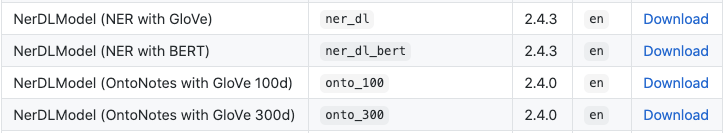

### Public NER (CoNLL 2003)

<p><strong>Named-Entity recognition</strong> is a well-known technique in information extraction it is also known as&nbsp;<strong>entity identification</strong>,&nbsp;<strong>entity chunking</strong>&nbsp;and&nbsp;<strong>entity extraction.</strong>&nbsp;Knowing the relevant tags for each article help in automatically categorizing the articles in defined hierarchies and enable smooth content discovery.

Entities

``` PERSON, LOCATION, ORGANIZATION, MISC ```

In [ ]:
public_ner = NerDLModel.pretrained("ner_dl", 'en') \
    .setInputCols(["document", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [ ]:
public_ner.extractParamMap()

{Param(parent='NerDLModel_d4424c9af5f4', name='engine', doc='Deep Learning engine used for this model'): 'tensorflow',
 Param(parent='NerDLModel_d4424c9af5f4', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='NerDLModel_d4424c9af5f4', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='NerDLModel_d4424c9af5f4', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): False,
 Param(parent='NerDLModel_d4424c9af5f4', name='batchSize', doc='Size of every batch'): 32,
 Param(parent='NerDLModel_d4424c9af5f4', name='classes', doc='get the tags used to trained this NerDLModel'): ['O',
  'B-ORG',
  'B-LOC',
  'B-PER',
  'I-PER',
  'I-ORG',
  'B-MISC',
  'I-LOC',
  'I-MISC'],
 Param(parent='NerDLModel_d4424c9af5f4', name='inputCols', doc='previous annotations columns, if renamed')

In [ ]:
public_ner.getClasses()

['O', 'B-ORG', 'B-LOC', 'B-PER', 'I-PER', 'I-ORG', 'B-MISC', 'I-LOC', 'I-MISC']

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# ner_dl model is trained with glove_100d. So we use the same embeddings in the pipeline
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d').\
    setInputCols(["document", 'token']).\
    setOutputCol("embeddings")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               glove_embeddings,
                               public_ner])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)

+------------+---------+
|       token|ner_label|
+------------+---------+
|      Unions|        O|
|representing|        O|
|     workers|        O|
|          at|        O|
|      Turner|    B-ORG|
|      Newall|    I-ORG|
|         say|        O|
|        they|        O|
|         are|        O|
|           '|        O|
|disappointed|        O|
|           '|        O|
|       after|        O|
|       talks|        O|
|        with|        O|
|    stricken|        O|
|      parent|        O|
|        firm|        O|
|     Federal|    B-ORG|
|       Mogul|    I-ORG|
|           .|        O|
|     TORONTO|    B-LOC|
|           ,|        O|
|      Canada|    B-LOC|
|           A|        O|
|      second|        O|
|        team|        O|
|          of|        O|
|  rocketeers|        O|
|   competing|        O|
|         for|        O|
|         the|        O|
|      #36;10|        O|
|     million|        O|
|      Ansari|   B-MISC|
|           X|   I-MISC|
|       Prize|   I-MISC|


### NerDL OntoNotes 100D

This pipeline is based on&nbsp;<strong>NerDLApproach</strong> annotator with <strong>Char CNN - BiLSTM</strong> and <strong>GloVe Embeddings</strong> on the <strong>OntoNotes</strong> corpus and supports the identification of 18 entities.</p><p>Following NER types are supported in this pipeline:</p><table><thead><tr><th>Type</th><th>Description</th></tr></thead><tbody><tr><td><code>PERSON</code></td><td>People, including fictional.</td></tr><tr><td><code>NORP</code></td><td>Nationalities or religious or political groups.</td></tr><tr><td><code>FAC</code></td><td>Buildings, airports, highways, bridges, etc.</td></tr><tr><td><code>ORG</code></td><td>Companies, agencies, institutions, etc.</td></tr><tr><td><code>GPE</code></td><td>Countries, cities, states.</td></tr><tr><td><code>LOC</code></td><td>Non-GPE locations, mountain ranges, bodies of water.</td></tr><tr><td><code>PRODUCT</code></td><td>Objects, vehicles, foods, etc. (Not services.)</td></tr><tr><td><code>EVENT</code></td><td>Named hurricanes, battles, wars, sports events, etc.</td></tr><tr><td><code>WORK_OF_ART</code></td><td>Titles of books, songs, etc.</td></tr><tr><td><code>LAW</code></td><td>Named documents made into laws.</td></tr><tr><td><code>LANGUAGE</code></td><td>Any named language.</td></tr><tr><td><code>DATE</code></td><td>Absolute or relative dates or periods.</td></tr><tr><td><code>TIME</code></td><td>Times smaller than a day.</td></tr><tr><td><code>PERCENT</code></td><td>Percentage, including &rdquo;%&ldquo;.</td></tr><tr><td><code>MONEY</code></td><td>Monetary values, including unit.</td></tr><tr><td><code>QUANTITY</code></td><td>Measurements, as of weight or distance.</td></tr><tr><td><code>ORDINAL</code></td><td>&ldquo;first&rdquo;, &ldquo;second&rdquo;, etc.</td></tr><tr><td><code>CARDINAL</code></td><td>Numerals that do not fall under another type.</td></tr></tbody></table>

Entities

``` 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART' ```

In [ ]:
onto_ner = NerDLModel.pretrained("onto_100", 'en') \
    .setInputCols(["document", "token", "embeddings"]) \
    .setOutputCol("ner")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               glove_embeddings,
                               onto_ner])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

onto_100 download started this may take some time.
Approximate size to download 13.5 MB
[OK!]


In [ ]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)


+------------+-------------+
|       token|    ner_label|
+------------+-------------+
|      Unions|            O|
|representing|            O|
|     workers|            O|
|          at|            O|
|      Turner|        B-ORG|
|      Newall|        I-ORG|
|         say|            O|
|        they|            O|
|         are|            O|
|           '|            O|
|disappointed|            O|
|           '|            O|
|       after|            O|
|       talks|            O|
|        with|            O|
|    stricken|            O|
|      parent|            O|
|        firm|            O|
|     Federal|        B-ORG|
|       Mogul|        I-ORG|
|           .|            O|
|     TORONTO|        B-GPE|
|           ,|            O|
|      Canada|        B-GPE|
|           A|            O|
|      second|    B-ORDINAL|
|        team|            O|
|          of|            O|
|  rocketeers|            O|
|   competing|            O|
|         for|            O|
|         the|

### NER with BertForTokenClassification

[BertForTokenClassification](https://nlp.johnsnowlabs.com/docs/en/transformers#bertfortokenclassification) can load Bert Models with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for Named-Entity-Recognition (NER) tasks.

For more examples of BertForTokenClassification models, please check [Transformers for Token Classification in Spark NLP notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/14.Transformers_for_Token_Classification_in_Spark_NLP.ipynb).


Pretrained models can be loaded with `pretrained()` of the companion object. The default model is `"bert_base_token_classifier_conll03"`, if no name is provided. <br/><br/>

**Here are Bert Based Token Classification models available in Spark NLP:**

<br/>

| Title                                                                                                                        | Name                                          | Language   |
|:-----------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------|:-----------|
| BERT Token Classification - NER CoNLL (bert_base_token_classifier_conll03)                                                   | bert_base_token_classifier_conll03            | en         |
| BERT Token Classification - NER OntoNotes (bert_base_token_classifier_ontonote)                                              | bert_base_token_classifier_ontonote           | en         |
| BERT Token Classification Large - NER CoNLL (bert_large_token_classifier_conll03)                                            | bert_large_token_classifier_conll03           | en         |
| BERT Token Classification Large - NER OntoNotes (bert_large_token_classifier_ontonote)                                       | bert_large_token_classifier_ontonote          | en         |
| BERT Token Classification - ParsBERT for Persian Language Understanding (bert_token_classifier_parsbert_armanner)            | bert_token_classifier_parsbert_armanner       | fa         |
| BERT Token Classification - ParsBERT for Persian Language Understanding (bert_token_classifier_parsbert_ner)                 | bert_token_classifier_parsbert_ner            | fa         |
| BERT Token Classification - ParsBERT for Persian Language Understanding (bert_token_classifier_parsbert_peymaner)            | bert_token_classifier_parsbert_peymaner       | fa         |
| BERT Token Classification - BETO Spanish Language Understanding (bert_token_classifier_spanish_ner)                          | bert_token_classifier_spanish_ner             | es         |
| BERT Token Classification - Swedish Language Understanding (bert_token_classifier_swedish_ner)                               | bert_token_classifier_swedish_ner             | sv         |
| BERT Token Classification - Turkish Language Understanding (bert_token_classifier_turkish_ner)                               | bert_token_classifier_turkish_ner             | tr         |
| DistilBERT Token Classification - NER CoNLL (distilbert_base_token_classifier_conll03)                                       | distilbert_base_token_classifier_conll03      | en         |
| DistilBERT Token Classification - NER OntoNotes (distilbert_base_token_classifier_ontonotes)                                 | distilbert_base_token_classifier_ontonotes    | en         |
| DistilBERT Token Classification - DistilbertNER for Persian Language Understanding (distilbert_token_classifier_persian_ner) | distilbert_token_classifier_persian_ner       | fa         |
| BERT Token Classification -  Few-NERD (bert_base_token_classifier_few_nerd)                                                  | bert_base_token_classifier_few_nerd           | en         |
| DistilBERT Token Classification -  Few-NERD (distilbert_base_token_classifier_few_nerd)                                      | distilbert_base_token_classifier_few_nerd     | en         |
| Named Entity Recognition for Japanese (BertForTokenClassification)                                                           | bert_token_classifier_ner_ud_gsd              | ja         |
| Detect PHI for Deidentification (BertForTokenClassifier)                                                                     | bert_token_classifier_ner_deid                | en         |
| Detect Clinical Entities (BertForTokenClassifier)                                                                            | bert_token_classifier_ner_jsl                 | en         |
| Detect Drug Chemicals (BertForTokenClassifier)                                                                               | bert_token_classifier_ner_drugs               | en         |
| Detect Clinical Entities (Slim version, BertForTokenClassifier)                                                              | bert_token_classifier_ner_jsl_slim            | en         |
| ALBERT Token Classification Base - NER CoNLL (albert_base_token_classifier_conll03)                                          | albert_base_token_classifier_conll03          | en         |
| ALBERT Token Classification Large - NER CoNLL (albert_large_token_classifier_conll03)                                        | albert_large_token_classifier_conll03         | en         |
| ALBERT Token Classification XLarge - NER CoNLL (albert_xlarge_token_classifier_conll03)                                      | albert_xlarge_token_classifier_conll03        | en         |
| DistilRoBERTa Token Classification - NER OntoNotes (distilroberta_base_token_classifier_ontonotes)                           | distilroberta_base_token_classifier_ontonotes | en         |
| RoBERTa Token Classification Base - NER CoNLL (roberta_base_token_classifier_conll03)                                        | roberta_base_token_classifier_conll03         | en         |
| RoBERTa Token Classification Base - NER OntoNotes (roberta_base_token_classifier_ontonotes)                                  | roberta_base_token_classifier_ontonotes       | en         |
| RoBERTa Token Classification Large - NER CoNLL (roberta_large_token_classifier_conll03)                                      | roberta_large_token_classifier_conll03        | en         |
| RoBERTa Token Classification Large - NER OntoNotes (roberta_large_token_classifier_ontonotes)                                | roberta_large_token_classifier_ontonotes      | en         |
| RoBERTa Token Classification For Persian (roberta_token_classifier_zwnj_base_ner)                                            | roberta_token_classifier_zwnj_base_ner        | fa         |
| XLM-RoBERTa Token Classification Base - NER XTREME (xlm_roberta_token_classifier_ner_40_lang)                                | xlm_roberta_token_classifier_ner_40_lang      | xx         |
| XLNet Token Classification Base - NER CoNLL (xlnet_base_token_classifier_conll03)                                            | xlnet_base_token_classifier_conll03           | en         |
| XLNet Token Classification Large - NER CoNLL (xlnet_large_token_classifier_conll03)                                          | xlnet_large_token_classifier_conll03          | en         |
| Detect Adverse Drug Events (BertForTokenClassification)                                                                      | bert_token_classifier_ner_ade                 | en         |
| Detect Anatomical Regions (BertForTokenClassification)                                                                       | bert_token_classifier_ner_anatomy             | en         |
| Detect Bacterial Species (BertForTokenClassification)                                                                        | bert_token_classifier_ner_bacteria            | en         |
| XLM-RoBERTa Token Classification Base - NER CoNLL (xlm_roberta_base_token_classifier_conll03)                                | xlm_roberta_base_token_classifier_conll03     | en         |
| XLM-RoBERTa Token Classification Base - NER OntoNotes (xlm_roberta_base_token_classifier_ontonotes)                          | xlm_roberta_base_token_classifier_ontonotes   | en         |
| Longformer Token Classification Base - NER CoNLL (longformer_base_token_classifier_conll03)                                  | longformer_base_token_classifier_conll03      | en         |
| Longformer Token Classification Base - NER CoNLL (longformer_large_token_classifier_conll03)                                 | longformer_large_token_classifier_conll03     | en         |
| Detect Chemicals in Medical text (BertForTokenClassification)                                                                | bert_token_classifier_ner_chemicals           | en         |
| Detect Chemical Compounds and Genes (BertForTokenClassifier)                                                                 | bert_token_classifier_ner_chemprot            | en         |
| Detect Cancer Genetics (BertForTokenClassification)                                                                          | bert_token_classifier_ner_bionlp              | en         |
| Detect Cellular/Molecular Biology Entities (BertForTokenClassification)                                                      | bert_token_classifier_ner_cellular            | en         |
| Detect concepts in drug development trials (BertForTokenClassification)                                                      | bert_token_classifier_drug_development_trials | en         |
| Detect Cancer Genetics (BertForTokenClassification)                                                                          | bert_token_classifier_ner_bionlp              | en         |
| Detect Adverse Drug Events (BertForTokenClassification)                                                                      | bert_token_classifier_ner_ade                 | en         |
| Detect Anatomical Regions (MedicalBertForTokenClassifier)                                                                    | bert_token_classifier_ner_anatomy             | en         |
| Detect Cellular/Molecular Biology Entities (BertForTokenClassification)                                                      | bert_token_classifier_ner_cellular            | en         |
| Detect Chemicals in Medical text (BertForTokenClassification)                                                                | bert_token_classifier_ner_chemicals           | en         |
| Detect Chemical Compounds and Genes (BertForTokenClassifier)                                                                 | bert_token_classifier_ner_chemprot            | en         |
| Detect PHI for Deidentification (BertForTokenClassifier)                                                                     | bert_token_classifier_ner_deid                | en         |
| Detect Drug Chemicals (BertForTokenClassifier)                                                                               | bert_token_classifier_ner_drugs               | en         |
| Detect Clinical Entities (BertForTokenClassifier)                                                                            | bert_token_classifier_ner_jsl                 | en         |
| Detect Clinical Entities (Slim version, BertForTokenClassifier)                                                              | bert_token_classifier_ner_jsl_slim            | en         |
| Detect Bacterial Species (BertForTokenClassification)                                                                        | bert_token_classifier_ner_bacteria            | en         |

**You can find all these models and more [HERE](https://nlp.johnsnowlabs.com/models?edition=Spark+NLP)**

In [ ]:
# no need for token columns
tokenClassifier = BertForTokenClassification.pretrained('bert_base_token_classifier_conll03', 'en') \
    .setInputCols('document',"token") \
    .setOutputCol("ner")

bert_base_token_classifier_conll03 download started this may take some time.
Approximate size to download 385.4 MB
[OK!]


In [ ]:
tokenClassifier.getClasses()

['B-LOC', 'I-ORG', 'I-MISC', 'I-LOC', 'I-PER', 'B-MISC', 'B-ORG', 'O', 'B-PER']

In [ ]:
ner_converter = NerConverter() \
    .setInputCols(["document", "token", "ner"]) \
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        tokenizer,
        tokenClassifier,
        ner_converter
        ])

result = nlpPipeline.fit(news_df).transform(news_df.limit(10))

result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+-------------------------------------------+---------+
|chunk                                      |ner_label|
+-------------------------------------------+---------+
|Turner   Newall                            |ORG      |
|Federal Mogul                              |ORG      |
|TORONTO                                    |LOC      |
|Canada                                     |LOC      |
|Ansari X Prize                             |MISC     |
|University of Louisville                   |ORG      |
|Mike Fitzpatrick                           |PER      |
|Southern California's                      |LOC      |
|British Department for Education and Skills|ORG      |
|DfES                                       |ORG      |
|Music Manifesto                            |MISC     |
|Netsky                                     |MISC     |
|Sasser                                     |MISC     |
|Sophos                                     |ORG      |
|Jaschan                                    |PER

### Multi-Lingual NER
These NER Models are able to extract entities from a variety of languages


#### Multi-Lingual NER (XLM-RoBERTa)
[XlmRoBertaForTokenClassification](https://nlp.johnsnowlabs.com/docs/en/transformers#xlmrobertafortokenclassification) can load XLM-RoBERTa Models with a token classification head on top (a linear layer on top of the hidden-states output) e.g. for Named-Entity-Recognition (NER) tasks.




| Spark NLP Model Name                     | language   | predicted_entities                                     | Class   | Number of Languages supported                    |
|:-----------------------------------------|:-----------|:-------------------------------------------------------|:--------------------------------|:-----------------------|
| ner_wikiner_glove_840B_300               | xx         | ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] | NerDLModel |8   |
| ner_wikiner_xlm_roberta_base             | xx         | ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] | NerDLModel |8   |
| ner_xtreme_glove_840B_300                | xx         | ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] | NerDLModel |40  |
| ner_xtreme_xlm_roberta_xtreme_base       | xx         | ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-PER', 'I-PER'] | NerDLModel |40  |
| xlm_roberta_token_classifier_ner_40_lang | xx         | ['LOC', 'ORG', 'PER', 'O']                             | XlmRoBertaForTokenClassification |40  |



In [ ]:
tokenClassifier = XlmRoBertaForTokenClassification() \
    .pretrained('xlm_roberta_token_classifier_ner_40_lang', 'xx') \
    .setInputCols(['token', 'document']) \
    .setOutputCol('ner')

xlm_roberta_token_classifier_ner_40_lang download started this may take some time.
Approximate size to download 921.6 MB
[OK!]


In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql import functions as F

# No need for NER Converter
nlpPipeline = Pipeline(stages=[documentAssembler,
                               tokenizer,
                               tokenClassifier,])

text = [
'Peter Parker is a nice lad and lives in New York',
'Das Schloss Charlottenburg in Berlin ist eines der schoensten Staedte in Deutschland sagen viele Menschen',
'Peter Parker est un gentil garçon et vit à New York',
'پیٹر پارکر ایک اچھا لڑکا ہے اور وہ نیو یارک میں رہتا ھے',
]
data_set = spark.createDataFrame(text, StringType()).toDF("text")
result = nlpPipeline.fit(data_set).transform(data_set)


result.select(F.explode(F.arrays_zip(result.token.result,
                                     result.ner.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias('token'),
              F.expr("cols['1']").alias("ner_label")).show(100,truncate=False)

+--------------+---------+
|token         |ner_label|
+--------------+---------+
|Peter         |PER      |
|Parker        |PER      |
|is            |O        |
|a             |O        |
|nice          |O        |
|lad           |O        |
|and           |O        |
|lives         |O        |
|in            |O        |
|New           |LOC      |
|York          |LOC      |
|Das           |O        |
|Schloss       |ORG      |
|Charlottenburg|ORG      |
|in            |O        |
|Berlin        |LOC      |
|ist           |O        |
|eines         |O        |
|der           |O        |
|schoensten    |O        |
|Staedte       |O        |
|in            |O        |
|Deutschland   |LOC      |
|sagen         |O        |
|viele         |O        |
|Menschen      |O        |
|Peter         |PER      |
|Parker        |PER      |
|est           |O        |
|un            |O        |
|gentil        |O        |
|garçon        |O        |
|et            |O        |
|vit           |O        |
|

## Highlight the entities

In [ ]:
# Install spark-nlp-display
! pip install -q spark-nlp-display

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

pipeline = PretrainedPipeline('recognize_entities_dl', lang='en')

recognize_entities_dl download started this may take some time.
Approx size to download 159 MB
[OK!]


In [ ]:
ann_text = pipeline.fullAnnotate('Peter Parker is a nice persn and lives in New York. Bruce Wayne is also a nice guy and lives in Gotham City.')[0]
ann_text.keys()

dict_keys(['entities', 'document', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()
visualiser.display(ann_text, label_col='entities', document_col='document')

# Change color of an entity label
visualiser.set_label_colors({'LOC':'#008080', 'PER':'#800080'})
visualiser.display(ann_text, label_col='entities')

# Set label filter
visualiser.display(ann_text, label_col='entities', document_col='document',
                   labels=['PER'])

print ('\nColor code for label: \n"LOC": {}\n"PER": {}' .format(visualiser.get_label_color('LOC'),visualiser.get_label_color('PER')) )


Color code for label: 
"LOC": #008080
"PER": #800080


## Using Pretrained ClassifierDL and SentimentDL models

| Name                                                                                | Spark NLP Model Reference                  | Language   |
|:------------------------------------------------------------------------------------|:-------------------------------------------|:-----------|
| TREC(50) Question Classifier                                                        | classifierdl_use_trec50                    | en         |
| TREC(6) Question Classifier                                                         | classifierdl_use_trec6                     | en         |
| Cyberbullying Classifier                                                            | classifierdl_use_cyberbullying             | en         |
| Emotion Detection Classifier                                                        | Emotion Classifier                         | en         |
| Fake News Classifier                                                                | classifierdl_use_fakenews                  | en         |
| Sarcasm Classifier                                                                  | classifierdl_use_sarcasm                   | en         |
| Spam Classifier                                                                     | classifierdl_use_spam                      | en         |
| Classifier for Adverse Drug Events                                                  | classifierdl_ade_biobert                   | en         |
| PICO Classifier                                                                     | classifierdl_pico_biobert                  | en         |
| Classifier for Genders - BIOBERT                                                    | classifierdl_gender_biobert                | en         |
| Classifier for Genders - SBERT                                                      | classifierdl_gender_sbert                  | en         |
| TREC(50) Question Classifier                                                        | classifierdl_use_trec50                    | en         |
| TREC(6) Question Classifier                                                         | classifierdl_use_trec6                     | en         |
| Cyberbullying Classifier                                                            | classifierdl_use_cyberbullying             | en         |
| Emotion Detection Classifier                                                        | classifierdl_use_emotion                   | en         |
| Fake News Classifier                                                                | classifierdl_use_fakenews                  | en         |
| Sarcasm Classifier                                                                  | classifierdl_use_sarcasm                   | en         |
| Spam Classifier                                                                     | classifierdl_use_spam                      | en         |
| Classifier for Adverse Drug Events                                                  | classifierdl_ade_biobert                   | en         |
| Classifier for Adverse Drug Events using Clinical Bert                              | classifierdl_ade_clinicalbert              | en         |
| Classifier for Adverse Drug Events in Small Conversations                           | classifierdl_ade_conversational_biobert    | en         |
| Classifier for Genders - BIOBERT                                                    | classifierdl_gender_biobert                | en         |
| Classifier for Genders - SBERT                                                      | classifierdl_gender_sbert                  | en         |
| PICO Classifier                                                                     | classifierdl_pico_biobert                  | en         |
| End-to-End (E2E) and data-driven NLG Challenge                                      | multiclassifierdl_use_e2e                  | en         |
| Toxic Comment Classification                                                        | multiclassifierdl_use_toxic                | en         |
| Toxic Comment Classification - Small                                                | multiclassifierdl_use_toxic_sm             | en         |
| Intent Classification for Airline Traffic Information System queries (ATIS dataset) | classifierdl_use_atis                      | en         |
| Identify intent in general text - SNIPS dataset                                     | classifierdl_use_snips                     | en         |
| News Classifier of Turkish text                                                     | classifierdl_bert_news                     | tr         |
| News Classifier of German text                                                      | classifierdl_bert_news                     | de         |
| Cyberbullying Classifier in Turkish texts.                                          | classifierdl_berturk_cyberbullying         | tr         |
| Question Pair Classifier                                                            | classifierdl_electra_questionpair          | en         |
| Question Pair Classifier Pipeline                                                   | classifierdl_electra_questionpair_pipeline | en         |
| News Classifier Pipeline for Turkish text                                           | classifierdl_bert_news_pipeline            | tr         |

In [ ]:
fake_classifier = ClassifierDLModel.pretrained('classifierdl_use_fakenews', 'en') \
                      .setInputCols(["sentence_embeddings"]) \
                      .setOutputCol("class")

classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]


fake_news classifier is trained on `https://raw.githubusercontent.com/joolsa/fake_real_news_dataset/master/fake_or_real_news.csv.zip`

In [ ]:
fake_classifier.getClasses()

['FAKE', 'REAL']

In [ ]:
documentAssembler = DocumentAssembler()\
                      .setInputCol("text")\
                      .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained(lang="en") \
          .setInputCols(["document"])\
          .setOutputCol("sentence_embeddings")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               use,
                               fake_classifier])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fake_clf_model = nlpPipeline.fit(empty_data)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/spam_ham_dataset.csv

In [ ]:
fake_lp_pipeline = LightPipeline(fake_clf_model)

text = 'BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump'

fake_lp_pipeline.annotate(text)

{'document': ['BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump'],
 'sentence_embeddings': ['BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump'],
 'class': ['FAKE']}

In [ ]:
sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------+
|text                                                                                             |
+-------------------------------------------------------------------------------------------------+
|BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump|
+-------------------------------------------------------------------------------------------------+



In [ ]:
pred = fake_clf_model.transform(sample_data)

pred.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|            document| sentence_embeddings|               class|
+--------------------+--------------------+--------------------+--------------------+
|BREAKING: Leaked ...|[{document, 0, 96...|[{sentence_embedd...|[{category, 0, 96...|
+--------------------+--------------------+--------------------+--------------------+



In [ ]:
pred.select('text','class.result').show(truncate=False)

+-------------------------------------------------------------------------------------------------+------+
|text                                                                                             |result|
+-------------------------------------------------------------------------------------------------+------+
|BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump|[FAKE]|
+-------------------------------------------------------------------------------------------------+------+



you can find more samples here >> `https://github.com/KaiDMML/FakeNewsNet/tree/master/dataset`


In [ ]:
fake_lp_pipeline = LightPipeline(fake_clf_model)

text = "Joseph Robinette Biden Jr. is an American politician who is the 46th and current president of the United States."

fake_lp_pipeline.annotate(text)


{'document': ['Joseph Robinette Biden Jr. is an American politician who is the 46th and current president of the United States.'],
 'sentence_embeddings': ['Joseph Robinette Biden Jr. is an American politician who is the 46th and current president of the United States.'],
 'class': ['REAL']}

## Generic classifier function

In [ ]:
def get_clf_lp(model_name, sentiment_dl=False, pretrained=True):

  documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

  use = UniversalSentenceEncoder.pretrained(lang="en") \
        .setInputCols(["document"])\
        .setOutputCol("sentence_embeddings")


  if pretrained:

    if sentiment_dl:

      document_classifier = SentimentDLModel.pretrained(model_name, 'en') \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.pretrained(model_name, 'en') \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCol("class")

  else:

    if sentiment_dl:

      document_classifier = SentimentDLModel.load(model_name) \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.load(model_name) \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCol("class")

  print ('classes:',document_classifier.getClasses())

  nlpPipeline = Pipeline(stages=[
                                documentAssembler,
                                use,
                                document_classifier
                                ])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  clf_pipelineFit = nlpPipeline.fit(empty_data)

  clf_lp_pipeline = LightPipeline(clf_pipelineFit)

  return clf_lp_pipeline

In [ ]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_trec50')

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_trec50 download started this may take some time.
Approximate size to download 21.2 MB
[OK!]
classes: [' ENTY_color', ' ENTY_techmeth', ' DESC_manner', ' NUM_volsize', ' ENTY_letter', ' NUM_temp', ' ENTY_body', ' NUM_count', ' ENTY_instru', ' NUM_period', ' NUM_speed', ' DESC_reason', ' ENTY_symbol', ' ENTY_event', ' HUM_desc', ' NUM_perc', ' ENTY_dismed', ' NUM_ord', ' HUM_gr', ' LOC_mount', ' ABBR_abb', ' DESC_desc', ' NUM_dist', ' HUM_title', ' ENTY_lang', ' ENTY_sport', ' ENTY_plant', ' NUM_code', ' NUM_other', ' ENTY_word', ' ENTY_animal', ' ENTY_substance', ' ENTY_veh', ' ENTY_product', ' LOC_state', ' ENTY_religion', ' ENTY_currency', ' NUM_date', ' LOC_country', ' ENTY_cremat', ' NUM_money', ' LOC_other', ' DESC_def', ' LOC_city', ' HUM_ind', ' ENTY_other', ' ENTY_termeq', ' ENTY_food', ' ABBR_exp', ' NUM_weight']


trained on the TREC datasets:

Classify open-domain, fact-based questions into one of the following broad semantic categories:

```Abbreviation, Description, Entities, Human Beings, Locations or Numeric Values.```

In [ ]:
text = 'What was the number of member nations of the U.N. in 2000?'

clf_lp_pipeline.annotate(text)['class']

[' NUM_count']

In [ ]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].result

' NUM_count'

In [ ]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].metadata

{' ENTY_dismed': '3.768739E-22', ' ENTY_product': '2.4015744E-24', ' ENTY_techmeth': '1.5787039E-22', ' NUM_speed': '7.948464E-23', ' NUM_volsize': '2.5315113E-25', ' LOC_state': '6.3784123E-25', ' NUM_code': '1.4549451E-25', ' NUM_count': '0.9992601', ' ENTY_food': '1.3031208E-24', ' ENTY_animal': '1.6743833E-24', ' NUM_period': '6.8075115E-21', ' ENTY_religion': '5.9194734E-23', ' LOC_country': '5.3062683E-21', ' LOC_mount': '3.2177816E-25', ' ENTY_termeq': '9.790085E-26', ' ENTY_color': '1.1446835E-22', ' ENTY_lang': '6.333391E-24', ' ENTY_sport': '8.0773835E-25', ' DESC_def': '2.4284432E-27', ' HUM_gr': '4.4863106E-21', ' ENTY_symbol': '4.1271923E-25', ' ENTY_currency': '8.156541E-29', ' ENTY_veh': '5.414701E-22', ' LOC_other': '5.5141072E-11', ' ENTY_word': '5.3265024E-23', ' NUM_temp': '2.0907158E-23', ' NUM_dist': '1.2542656E-24', ' DESC_desc': '1.0926973E-12', ' DESC_manner': '9.258374E-23', ' NUM_ord': '2.2395288E-25', ' NUM_other': '3.9771262E-27', ' DESC_reason': '1.1718967E

In [ ]:
text = 'What animal was the first mammal successfully cloned from adult cells?'

clf_lp_pipeline.annotate(text)['class']

[' HUM_ind']

In [ ]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_cyberbullying')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_cyberbullying download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
classes: ['sexism', 'neutral', 'racism']


In [ ]:
text ='RT @EBeisner @ahall012 I agree with you!! I would rather brush my teeth with sandpaper then watch football with a girl!!'

clf_lp_pipeline.annotate(text)['class']

['sexism']

In [ ]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_fakenews')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
classes: ['FAKE', 'REAL']


In [ ]:
text ='Donald Trump a KGB Spy? 11/02/2016 In today’s video, Christopher Greene of AMTV reports Hillary Clinton campaign accusation that Donald Trump is a KGB spy is about as weak and baseless a claim as a Salem witch hunt or McCarthy era trial. It’s only because Hillary Clinton is losing that she is lobbing conspiracy theory. Citizen Quasar The way I see it, one of two things will happen: 1. Trump will win by a landslide but the election will be stolen via electronic voting, just like I have been predicting for over a decade, and the American People will accept the skewed election results just like they accept the TSA into their crotches. 2. Somebody will bust a cap in Hillary’s @$$ killing her and the election will be postponed. Follow AMTV!'

clf_lp_pipeline.annotate(text)['class']


['FAKE']

In [ ]:
text ='Sen. Marco Rubio (R-Fla.) is adding a veteran New Hampshire political operative to his team as he continues mulling a possible 2016 presidential bid, the latest sign that he is seriously preparing to launch a campaign later this year.Jim Merrill, who worked for former GOP presidential nominee Mitt Romney and ran his 2008 and 2012 New Hampshire primary campaigns, joined Rubio’s fledgling campaign on Monday, aides to the senator said.Merrill will be joining Rubio’s Reclaim America PAC to focus on Rubio’s New Hampshire and broader Northeast political operations."Marco has always been well received in New Hampshire, and should he run for president, he would be very competitive there," Terry Sullivan, who runs Reclaim America, said in a statement. "Jim certainly knows how to win in New Hampshire and in the Northeast, and will be a great addition to our team at Reclaim America.”News of Merrill’s hire was first reported by The New York Times.'

clf_lp_pipeline.annotate(text)['class']

['REAL']

In [ ]:
sentiment_lp_pipeline = get_clf_lp('sentimentdl_use_twitter', sentiment_dl=True)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]
classes: ['positive', 'negative']


In [ ]:
text ='I am SO happy the news came out in time for my birthday this weekend! My inner 7-year-old cannot WAIT!'

sentiment_lp_pipeline.annotate(text)['class']

['positive']

In [ ]:
sentiment_lp_pipeline = get_clf_lp('classifierdl_use_emotion', sentiment_dl=False)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
classes: ['joy', 'fear', 'surprise', 'sadness']


In [ ]:
sentiment_lp_pipeline.annotate(text)['class']

['surprise']